In [2]:
!python --version

Python 3.9.5


In [6]:
!pip install cufflinks

     |████████████████████████████████| 81 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 22.8 MB/s eta 0:00:01
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67920 sha256=3a83c76366f854b5b213af03a861ff6d846b7530a64e4e21e0fb3e659919fcb9
  Stored in directory: /Users/nastja/Library/Caches/pip/wheels/29/b4/f8/2fd2206eeeba6ccad8167e4e8894b8c4ec27bf1342037fd136
Successfully built cufflinks


# Sex-related Crimes in NYC (2006-2021)

In [1]:
import pandas as pd
from tqdm import tqdm
import missingno as msgno

from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cufflinks as cf
from IPython.display import display,HTML

#making all charts public and setting a global theme
sns.set()
cf.set_config_file(sharing='public',theme='white',offline=True)

## I. Load & clean data

In [5]:
URL_NYPD_COMPLAINT_DATA = 'https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD'

df_cmp = pd.read_csv(URL_NYPD_COMPLAINT_DATA)
df_cmp.head()

In [2]:
df_cmp = pd.read_csv('../data/01-nypd-complaints.csv')
df_cmp.head()

/Users/nastja/.pyenv/versions/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning:

Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.



,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,394506329,12/31/2019,17:30:00,NaN,NaN,32.0,12/31/2019,118,DANGEROUS WEAPONS,793.0,...,NaN,NaN,40.820927,-73.943324,"(40.82092679700002, -73.94332421899996)",PATROL BORO MAN NORTH,NaN,UNKNOWN,UNKNOWN,E
1,968873685,12/29/2019,16:31:00,12/29/2019,16:54:00,47.0,12/29/2019,113,FORGERY,729.0,...,NaN,NaN,40.885701,-73.861640,"(40.885701406000074, -73.86164032499995)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
2,509837549,12/15/2019,18:45:00,NaN,NaN,109.0,12/29/2019,578,HARRASSMENT 2,638.0,...,M,NaN,40.742281,-73.819824,"(40.74228115600005, -73.81982408)",PATROL BORO QUEENS NORTH,NaN,25-44,WHITE HISPANIC,F
3,352454313,12/28/2019,01:00:00,NaN,NaN,47.0,12/28/2019,126,MISCELLANEOUS PENAL LAW,117.0,...,M,NaN,40.875311,-73.847545,"(40.87531145100007, -73.84754521099995)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
4,248803469,09/05/2008,21:41:00,NaN,NaN,NaN,09/05/2008,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,NaN,40.698827,-73.938819,"(40.698827283, -73.938819047)",NaN,NaN,25-44,BLACK,M


There are 35 columns this dataset. Some of them are pretty straightforward, such as the ones standing for suspects' sex, race and age (**SUSP_AGE_GROUP**, **SUSP_RACE**, **SUSP_SEX**). Others need a clariification.

Here is description from the official website:

* **CMPLNT_NUM** - complaint ID
* **CMPLNT_FR_DT** - start date of occurence of the reported event
* **CMPLNT_FR_TM** - start time of occurence of the reported event
* **CMPLNT_TO_DT** - end date of occurence of the reported event
* **CMPLNT_TO_TM** - end date of occurence of the reported event
* **ADDR_PCT_CD** - incident precinct
* **RPT_DT** - date incident was reported to the police
* **KY_CD** - key code of the offense
* **OFNS_DESC** - offense description (corresponds to a _key code_)
* **PD_CD** - offense internal classification code (more granular than _key code_)
* **PD_DESC** - internal classification description
* **CRM_ATPT_CPTD_CD** - Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely
* **LAW_CAT_CD** - Level of offense: felony, misdemeanor, violation
* **BORO_NM** - The name of the borough in which the incident occurred
* **LOC_OF_OCCUR_DESC** - Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of
* **PREM_TYP_DESC** - Specific description of premises; grocery store, residence, street, etc.
* **JURIS_DESC** - Description of the jurisdiction code
* **JURISDICTION_CODE** - Jurisdiction responsible for incident. Either internal, like Police(0), Transit(1), and Housing(2); or external(3), like Correction, Port Authority, etc.
* **PARKS_NM** - Name of NYC park, playground or greenspace of occurrence, if applicable (state parks are not included)
* **HADEVELOPT** - Name of NYCHA housing development of occurrence, if applicable
* **HOUSING_PSA** - Development Level Code
* **TRANSIT_DISTRICT** - Transit district in which the offense occurred.
* **PATROL_BORO** - The name of the patrol borough in which the incident occurred
* **STATION_NAME** - Transit station name

In [3]:
DROP_COLS = ['HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD', 'Lat_Lon', 'Latitude', 'Longitude',
            'STATION_NAME', 'PD_CD', 'JURISDICTION_CODE']

df_cmp = df_cmp.drop(DROP_COLS, axis=1)\
               .rename(columns={
             'CMPLNT_NUM': 'cmp_id',
             'CMPLNT_FR_DT': 'date_start',
             'CMPLNT_FR_TM': 'time_start',
             'CMPLNT_TO_DT': 'date_end',
             'CMPLNT_TO_TM': 'time_end',
             'ADDR_PCT_CD': 'loc_precinct',
             'RPT_DT': 'date_reported',
             'KY_CD': 'key_code',
             'OFNS_DESC': 'offense_desc',
             'PD_CD': 'internal_code',
             'PD_DESC': 'internal_desc',
             'CRM_ATPT_CPTD_CD': 'crime_result',
             'LAW_CAT_CD': 'offense_level',
             'BORO_NM': 'loc_borough',
             'LOC_OF_OCCUR_DESC': 'loc_position',
             'PREM_TYP_DESC': 'loc_premises',
             'JURIS_DESC': 'jurisdiction_desc',
             'PARKS_NM': 'park_name',
             'TRANSIT_DISTRICT': 'transit_district',
             'PATROL_BORO': 'loc_borough_patrol',
             'SUSP_AGE_GROUP': 'susp_age_group',
             'SUSP_RACE': 'susp_race',
             'SUSP_SEX': 'susp_sex',
             'VIC_AGE_GROUP': 'vic_age_group',
             'VIC_RACE': 'vic_race',
             'VIC_SEX': 'vic_sex',
             'Y_COORD_CD': 'x',
             'X_COORD_CD': 'y',
        })

In [4]:
df_cmp.shape

(7375993, 25)

<AxesSubplot:>

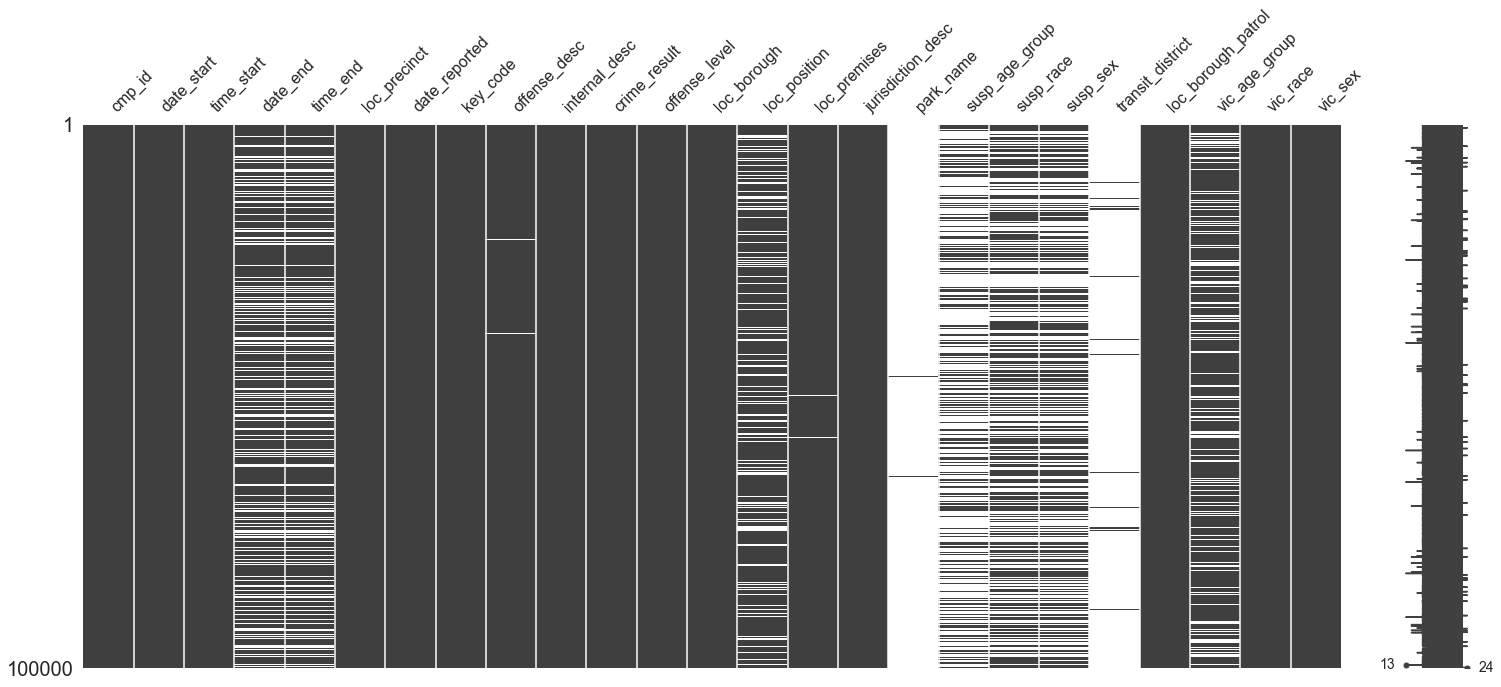

In [6]:
msgno.matrix(df_cmp.sample(100000))

Dataset contains 7.3 ml complaints, issued between 2006 and 2021 in NYC.

Matrix plot above demonstrates the missing values in teh data. We see that for many offenses, end timestamp is missing. A few complaints are missing offense description (but it might be regained via the offense key code, which has a one-to-one match eith offense type).

Victim's sex and race are well known, but we often miss the age group.
As for teh suspect's identity, we rarely who much about the offender.

<AxesSubplot:>

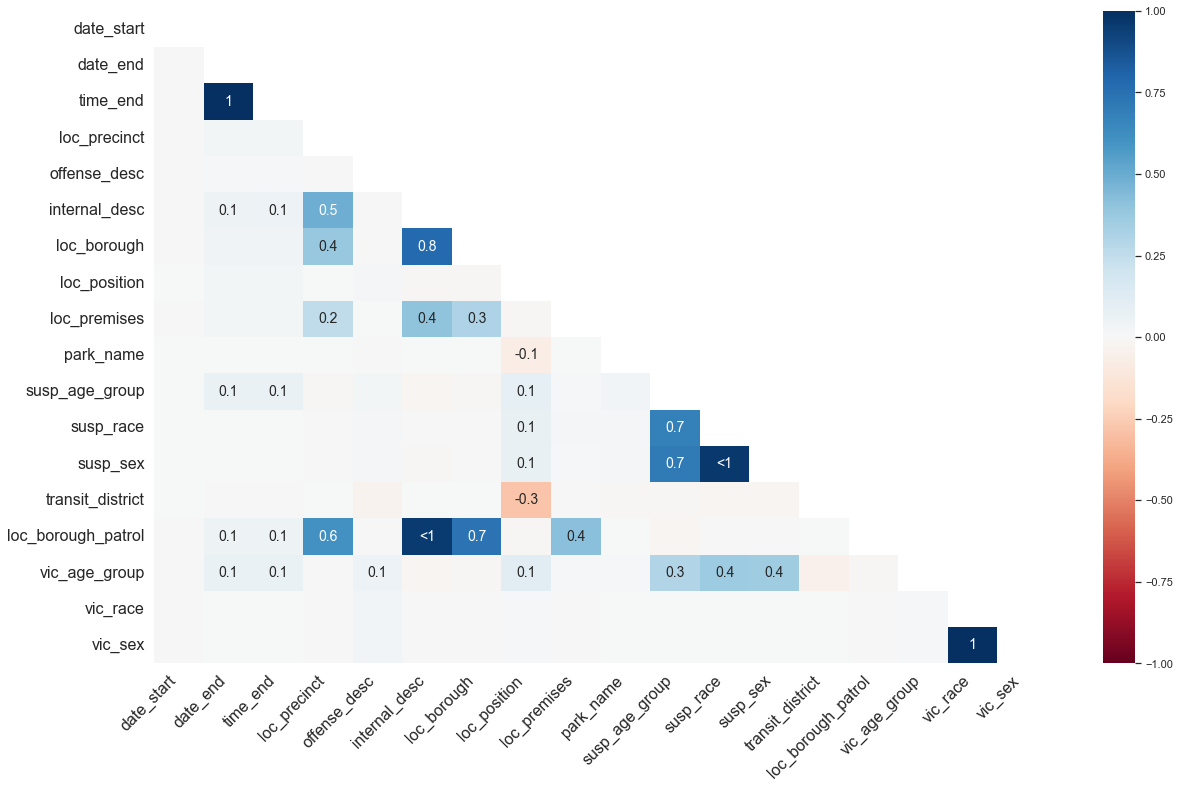

In [7]:
msgno.heatmap(df_cmp.sample(100000))

## Fix missing offense description

Wwe are missing offense type in 18k complaints. However, it seems that in most of these case it is possible to regain the description via the key code, that. isuniquely matched with teh description.

In [8]:
df_cmp[df_cmp.offense_desc.isnull()][['key_code', 'internal_desc']].key_code.unique()

array([126, 361, 360, 364, 578, 678, 106, 675, 359, 356, 344, 233, 117,
       116, 109, 121, 350, 235, 347, 236, 341, 112, 352, 351, 355, 105,
       358, 343, 230, 366, 340, 232, 348, 125, 111, 107, 365, 237, 124])

In [9]:
# create a map of code to description and use it to fill in missing descriptions
map_keycode_to_desc = dict(list(df_cmp[['key_code', 'offense_desc']]\
                                .drop_duplicates().dropna()\
                                .to_records(index=False)))
df_cmp.offense_desc = df_cmp.key_code.map(map_keycode_to_desc)

#### 1. Preprocess dates

In [10]:
# percentage of rows with no start time indicated
pct_rows_no_time_start = df_cmp[df_cmp.time_start.isnull()].shape[0] / df_cmp.shape[0] * 100
print(f'% rows with missing start time: {pct_rows_no_time_start:.6f}%')

# rows with missing start date
pct_rows_no_date_start = df_cmp[df_cmp.date_start.isnull()].shape[0] / df_cmp.shape[0] * 100
print(f'% rows with missing start date: {pct_rows_no_date_start:.6f}%')

df_cmp = df_cmp[~(df_cmp.date_start.isnull() | df_cmp.time_start.isnull())]
print(df_cmp.shape[0])

% rows with missing start time: 0.000651%
% rows with missing start date: 0.008880%
7375291


A few complaints are missing the start date and time. Since it is very few data points, we can remove them whicle still having alot of points to work with

In [15]:
df_cmp[pd.to_datetime(df_cmp.date_start,  errors = 'coerce').isnull()]/
    .offense_desc.value_counts()

PETIT LARCENY                     34
HARRASSMENT 2                     21
CRIMINAL MISCHIEF & RELATED OF    15
ASSAULT 3 & RELATED OFFENSES      11
GRAND LARCENY                      9
SEX CRIMES                         7
FELONY ASSAULT                     4
OFF. AGNST PUB ORD SENSBLTY &      3
MISCELLANEOUS PENAL LAW            3
BURGLARY                           3
DANGEROUS DRUGS                    2
VEHICLE AND TRAFFIC LAWS           2
THEFT-FRAUD                        2
OFFENSES AGAINST PUBLIC ADMINI     2
FRAUDS                             2
FORGERY                            1
RAPE                               1
GRAND LARCENY OF MOTOR VEHICLE     1
ADMINISTRATIVE CODE                1
UNAUTHORIZED USE OF A VEHICLE      1
ROBBERY                            1
Name: offense_desc, dtype: int64

In [11]:
pbar = tqdm(range(0,10))

df_cmp.date_start = df_cmp.date_start.str.replace(f'1020', f'2020')

for i in pbar:
    pbar.set_description(f"Correcting 101{i} & 102{i} -> 201{i}")
    df_cmp.date_start = df_cmp.date_start.str.replace(f'101{i}', f'201{i}')
    df_cmp.date_start = df_cmp.date_start.str.replace(f'102{i}', f'201{i}')
    
    df_cmp.date_end = df_cmp.date_end.str.replace(f'101{i}', f'201{i}')
    df_cmp.date_end = df_cmp.date_end.str.replace(f'102{i}', f'201{i}')

Correcting 1019 & 1029 -> 2019: 100%|███████████| 10/10 [03:32<00:00, 21.24s/it]


In [12]:
df_cmp.date_start = pd.to_datetime(df_cmp.date_start,  errors = 'coerce')
df_cmp.date_reported = pd.to_datetime(df_cmp.date_reported,  errors = 'coerce')

In [140]:
#in 23% of cases we have no information about the end date of the incident
df_cmp[df_cmp.date_end.isnull()].shape[0] / df_cmp.shape[0] * 100

23.104796814118927

#### 2. Clean age groups

In [13]:
AGE_GROUPS_VALID = ['<18', '18-24', '25-44', '45-64', '65+', 'UNKNOWN']

In [14]:
df_cmp[~(df_cmp.susp_age_group.isin(AGE_GROUPS_VALID) & df_cmp.vic_age_group.isin(AGE_GROUPS_VALID))].shape[0]\
    /df_cmp.shape[0]

0.6674737308670261

In [15]:
map_age_group = lambda age: age if age in AGE_GROUPS_VALID else 'UNKNOWN'

df_cmp.susp_age_group = df_cmp.susp_age_group.apply(map_age_group)
df_cmp.vic_age_group = df_cmp.vic_age_group.apply(map_age_group)

In [16]:
df_cmp.vic_age_group.value_counts()

25-44      2433625
UNKNOWN    2325200
45-64      1268223
18-24       749381
<18         339234
65+         259628
Name: vic_age_group, dtype: int64

<AxesSubplot:xlabel='vic_age_group', ylabel='susp_age_group'>

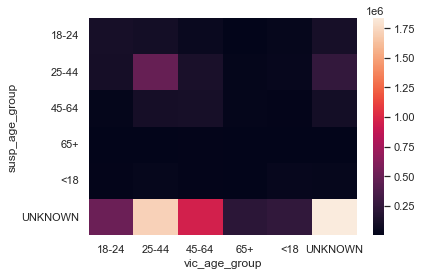

In [22]:
sns.heatmap(df_cmp.groupby(['susp_age_group', 'vic_age_group']).count().cmp_id.unstack())

In [19]:
!pip install pyarrow

     |████████████████████████████████| 17.6 MB 559 kB/s eta 0:00:01    |█████████████████▌              | 9.7 MB 408 kB/s eta 0:00:20     |████████████████████████████    | 15.4 MB 476 kB/s eta 0:00:05


In [28]:
df_cmp.reset_index(drop=True).to_csv('../data/01-nypd-complaints-clean.csv')

# Q1: Did the sexual violence go down in the last 10 years?

In [42]:
df_cmp = pd.read_csv('../data/01-nypd-complaints-clean.csv')
df_cmp.date_start = pd.to_datetime(df_cmp.date_start)
df_cmp.date_reported = pd.to_datetime(df_cmp.date_reported)

In [43]:
df_cmp = df_cmp.drop(['Unnamed: 0', 'cmp_id', 'key_code', 'park_name', 'transit_district',
                      'loc_borough_patrol', 'time_end', 'date_end', 'loc_position', 'jurisdiction_desc'], axis=1)

In [44]:
SEX_OFFENSES = ["SEX CRIMES", "RAPE"]
df_sex_offenses = df_cmp.query('offense_desc in @SEX_OFFENSES')

In [45]:
# merge all sex offenses into one category
df_cmp.offense_desc = df_cmp.offense_desc.apply(lambda of: 'SEX CRIMES' if of == 'RAPE' else of)
df_sex_offenses.internal_desc = df_sex_offenses.internal_desc\
    .apply(lambda of:'RAPE' if of.startswith('RAPE') else of)

df_sex_offenses.internal_desc.value_counts().head(10)

SEXUAL ABUSE 3,2                  42766
CHILD, ENDANGERING WELFARE        22335
RAPE                              21648
SEXUAL MISCONDUCT,INTERCOURSE      4626
SEXUAL MISCONDUCT,DEVIATE           348
OBSCENITY, PERFORMANCE 3             98
OBSCENITY, MATERIAL 3                30
SEXUAL ABUSE                          8
SODOMY,CONSENSUAL                     3
PUBLIC ADMINISTATION,UNCLASS M        2
Name: internal_desc, dtype: int64

In [46]:
# map subcategories into a bigger group
SEX_OFFENSE_CATEGORY_MAP = {
    'SEXUAL ABUSE 3,2': 'SEX_ABUSE',
    'CHILD, ENDANGERING WELFARE': 'CHILD_ENDANGERING',
    'SEXUAL MISCONDUCT,INTERCOURSE': 'SEXUAL_MISCONDUCT',
    'SEXUAL MISCONDUCT,DEVIATE': 'SEXUAL_MISCONDUCT',
    'OBSCENITY, PERFORMANCE 3': 'OBSCENITY',
    'OBSCENITY, MATERIAL 3': 'OBSCENITY',
    'SEXUAL ABUSE': 'SEX_ABUSE'
    }

df_sex_offenses.internal_desc = df_sex_offenses.internal_desc.map(SEX_OFFENSE_CATEGORY_MAP)
df_sex_offenses.dropna(subset=['internal_desc'], inplace=True)
df_sex_offenses.internal_desc.value_counts(dropna=False)

SEX_ABUSE            42774
CHILD_ENDANGERING    22335
SEXUAL_MISCONDUCT     4974
OBSCENITY              128
Name: internal_desc, dtype: int64

In [47]:
df_sex_offenses.loc_borough.value_counts()

BROOKLYN         22074
MANHATTAN        17326
QUEENS           15639
BRONX            12840
STATEN ISLAND     2287
Name: loc_borough, dtype: int64

In [77]:
weekly_offenses = df_sex_offenses.groupby(['loc_borough', df_sex_offenses.date_start.dt.year, df_sex_offenses.date_start.dt.week])\
    .count().groupby(level=[0,1]).mean()\
    .date_start\
    .loc[:,2006:].unstack().astype(int).T
weekly_offenses

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_8847/1483302737.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



loc_borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
date_start,,,,,
2006,14,32,19,21,3
2007,14,30,19,17,3
2008,13,29,20,17,2
2009,15,27,19,20,3
2010,14,26,18,21,2
2011,15,26,19,24,2
2012,16,28,18,18,2
2013,14,23,19,16,2
2014,17,24,20,16,2


In [96]:
weekly_offenses_all = df_cmp.groupby(['offense_desc', df_cmp.date_start.dt.year, df_cmp.date_start.dt.week])\
    .count().fillna(0).groupby(level=[0,1]).mean().date_start\
    .loc[:,2006:].unstack().T.fillna(0).astype(int).sort_index()
weekly_offenses_all

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_8847/2909353935.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



offense_desc,ABORTION,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CRIMINAL MISCHIEF & RELATED OF,...,PETIT LARCENY OF MOTOR VEHICLE,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,ROBBERY,SEX CRIMES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNDER THE INFLUENCE OF DRUGS,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS
date_start,,,,,,,,,,,,,,,,,,,,,
2006,0,22,1,1,1,32,990,3,441,1018,...,3,58,1,439,121,111,24,0,1,111
2007,1,21,1,2,1,30,981,3,416,1073,...,2,56,2,411,110,117,25,0,1,105
2008,0,22,1,1,1,35,966,3,398,1082,...,2,54,2,430,108,128,22,0,1,100
2009,0,23,0,2,1,27,946,4,366,984,...,2,53,1,350,108,95,22,1,1,116
2010,0,21,1,2,1,27,993,4,352,961,...,1,58,2,369,110,96,24,0,1,125
2011,0,22,1,2,1,24,978,5,362,947,...,1,70,2,380,116,108,25,0,1,111
2012,0,22,1,2,1,24,1048,5,371,919,...,2,65,2,387,112,118,27,0,1,107
2013,1,21,1,1,1,22,1029,5,335,844,...,2,57,2,367,103,96,29,0,1,117
2014,0,21,0,2,1,22,1034,7,323,916,...,2,48,3,318,106,90,32,1,1,112


In [182]:
top_20 = weekly_offenses_all.sum().sort_values().tail(20).index
weekly_offenses_all[top_20]

offense_desc,FORGERY,THEFT-FRAUD,CRIMINAL TRESPASS,SEX CRIMES,VEHICLE AND TRAFFIC LAWS,INTOXICATED & IMPAIRED DRIVING,GRAND LARCENY OF MOTOR VEHICLE,OFFENSES AGAINST PUBLIC ADMINI,DANGEROUS WEAPONS,MISCELLANEOUS PENAL LAW,BURGLARY,ROBBERY,FELONY ASSAULT,OFF. AGNST PUB ORD SENSBLTY &,DANGEROUS DRUGS,GRAND LARCENY,CRIMINAL MISCHIEF & RELATED OF,ASSAULT 3 & RELATED OFFENSES,HARRASSMENT 2,PETIT LARCENY
date_start,,,,,,,,,,,,,,,,,,,,
2006,121,111,123,121,111,133,300,104,201,217,441,439,326,650,645,884,1018,990,1319,1538
2007,115,117,154,110,105,165,252,185,243,209,416,411,333,638,766,857,1073,981,1250,1533
2008,97,128,160,108,100,158,239,199,248,214,398,430,312,600,743,841,1082,966,1173,1595
2009,88,95,161,108,116,144,200,211,269,219,366,350,316,583,747,735,984,946,1104,1521
2010,90,96,145,110,125,126,194,210,266,215,352,369,323,571,734,718,961,993,1082,1536
2011,77,108,131,116,111,115,178,212,262,220,362,380,357,539,739,748,947,978,1043,1560
2012,73,118,111,112,107,129,155,206,232,232,371,387,376,527,666,826,919,1048,1096,1599
2013,81,96,95,103,117,158,141,205,224,252,335,367,392,518,566,875,844,1029,1108,1637
2014,92,90,99,106,112,151,147,198,207,264,323,318,389,378,553,852,916,1034,1193,1636


In [138]:
# top 20 by number of weekly complaints
top_20_offenses = weekly_offenses_all.sum().sort_values().tail(20)
top_20_offenses.index = [i.lower().capitalize() for i in top_20_offenses.index]
top_20_offenses = top_20_offenses.iloc[::-1]
top_20_offenses

Petit larceny                     23726
Harrassment 2                     18035
Assault 3 & related offenses      14781
Criminal mischief & related of    14212
Grand larceny                     12122
Dangerous drugs                    8154
Off. agnst pub ord sensblty &      7295
Felony assault                     5459
Robbery                            5081
Burglary                           4847
Miscellaneous penal law            3577
Dangerous weapons                  3076
Offenses against public admini     2620
Grand larceny of motor vehicle     2549
Intoxicated & impaired driving     1832
Vehicle and traffic laws           1746
Sex crimes                         1713
Criminal trespass                  1563
Theft-fraud                        1403
Forgery                            1379
dtype: int64

In [172]:
map_offense_names = {of: of for of in top_20_offenses.index}
map_offense_names.update({'Off. agnst pub ord sensblty &':'Offense aganist public sensibility',
                          'Assault 3 & related offenses': 'Assalut, 3rd degree',
                          'Offenses against public admini': 'Offense against public administration',
                          'Harrassment 2': 'Harrassment, 2nd degree',
                          'Criminal mischief & related of': 'Criminal mischief'})
top_20_offenses.index = top_20_offenses.index.map(map_offense_names)

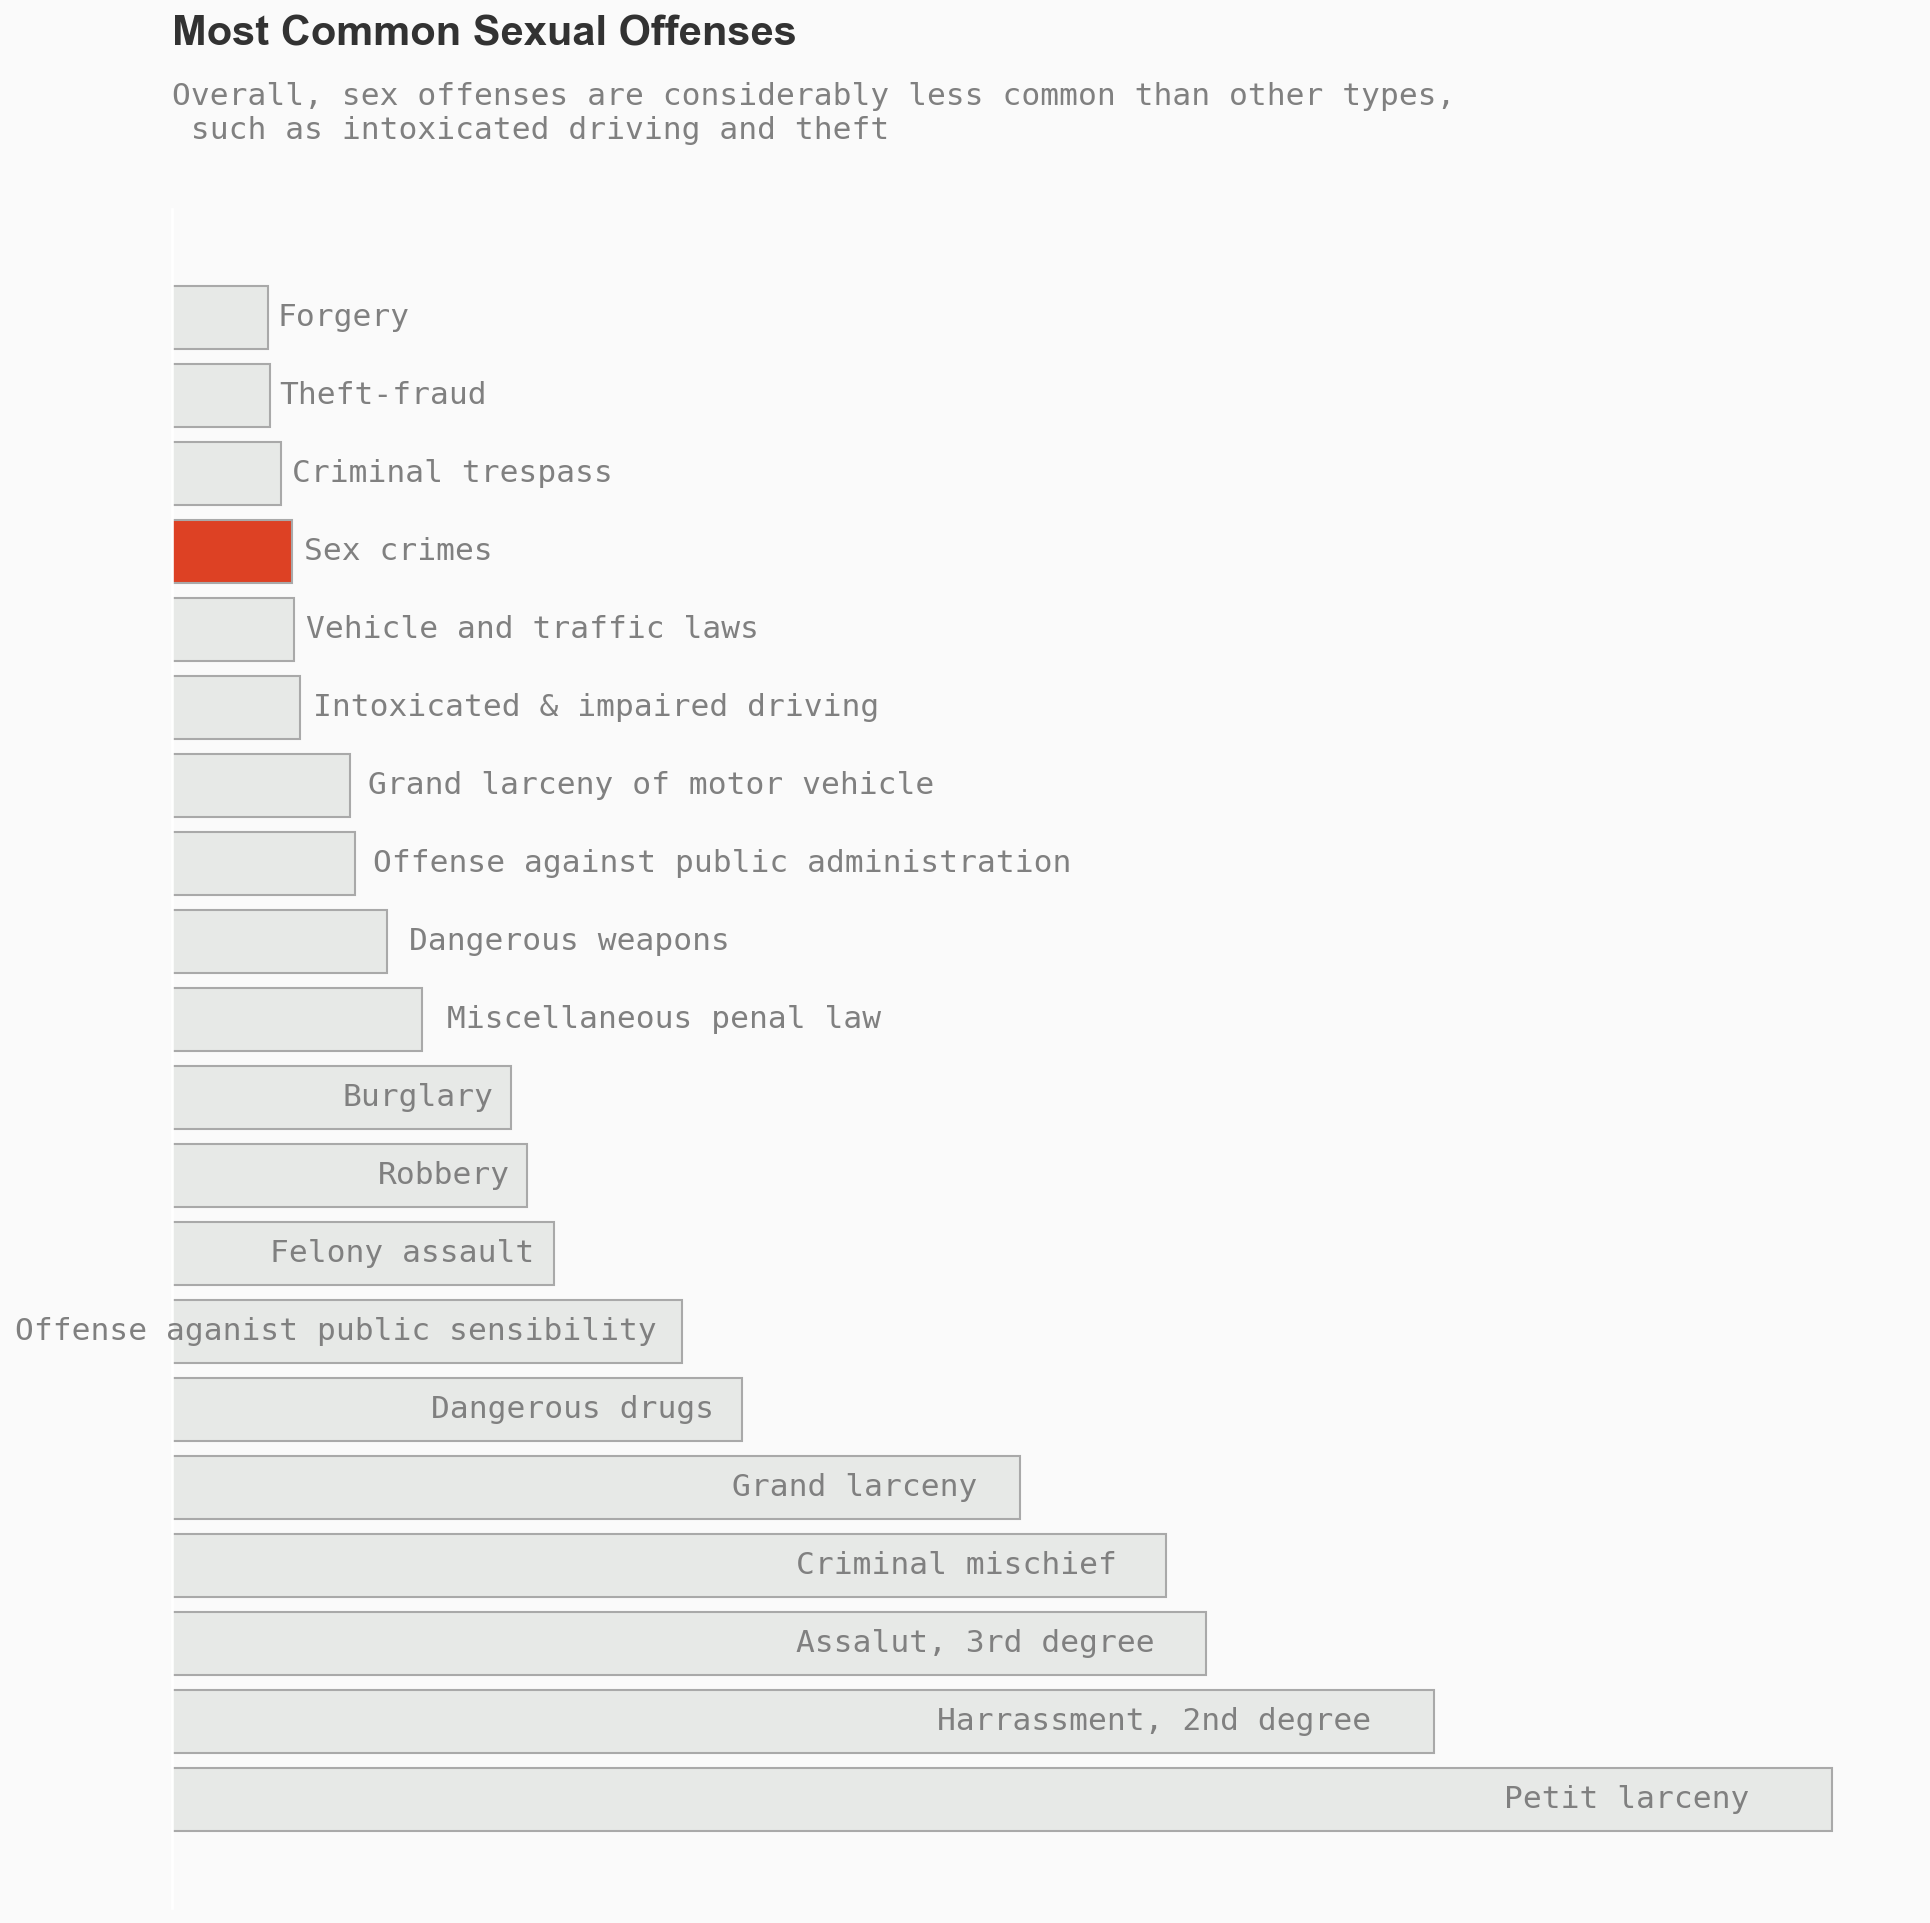

In [175]:
fig = plt.figure(figsize=(15,15),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 


# Plots 
# Happiest
data = top_20_offenses

color_map = ['#e7e9e7' for _ in range(20)]
color_map[16] =  low_c # color highlight
#color_map[17] = color_map[18] = color_map[19] =  high_c 
#base
ax0.barh(data.index, 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax0.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)

for i in range(0,10):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-data[i]*0.05, i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)
for i in range(10,20):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i] + data[i]*0.1, i), 
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)
# diff color text
#for i in range(17,20):
#    ax0.annotate(list(data.index)[i], 
#                   xy=(data[i]+(data[i]*0.1), i), 
#                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
    

ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])


for s in ['top', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    
ax0.text(0,22.5,'Most Common Sexual Offenses',fontfamily='sans-serif',fontsize=20,fontweight='bold',color='#323232')
ax0.text(0,21.3,'Sex offenses are considerably less common than other types,\n such as intoxicated driving and theft',fontfamily='monospace',fontsize=15,fontweight='light',color='gray')

plt.show()

In [ ]:
background = "#fbfbfb"
fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color
ax.set_facecolor(background)

# Reduced list as too many to show all at once 
top_list_ = weekly_offenses_all[top_20]


plot = 1
for country in top_list_['Country']:
    mean = df2[df2['Country'] == country].groupby('Country')['Life Ladder'].mean()
    # historic scores
    sns.scatterplot(data=df2[df2['Country'] == country], y=plot, x='Life Ladder',color='lightgray',s=50,ax=ax)
    # mean score
    sns.scatterplot(data=df2[df2['Country'] == country], y=plot, x=mean,color='gold',ec='black',linewidth=1,s=75,ax=ax)
    #2021 score
    sns.scatterplot(data=df[df['Country'] == country], y=plot, x='Ladder score',color=high_c,ec='black',linewidth=1,s=75,ax=ax)   
    plot += 1
    
ax.set_yticks(top_list_.index+1)
ax.set_yticklabels(top_list_['Country'][::-1], fontdict={'horizontalalignment': 'right'}, alpha=0.7)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Happiness Index Score",fontfamily='monospace',loc='left',color='gray')


for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.hlines(y=top_list_.index+1, xmin=Xstart, xmax=Xend, color='gray', alpha=0.5, linewidth=.3, linestyles='--')
ax.set_axisbelow(True)
ax.text(6.25, Yend+4.3, 'Happiness Index Scores through the years', fontsize=17, fontweight='bold', fontfamily='sansserif',color='#323232')
ax.text(6.25, Yend+0.75,
'''
Countries scores do vary over time, however they remain  farily consistent
It is interesting that Finland's 2021 score is amongst the highest of all time
''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')

plt.annotate('2021\nscore', xy=(7.842, 19), xytext=(8.2, 11),
             arrowprops=dict(facecolor='steelblue',arrowstyle="->",connectionstyle="arc3,rad=.3"), fontsize=10,fontfamily='monospace',ha='center', color=high_c)

plt.annotate('Mean\nscore', xy=(7.6804, 20), xytext=(8.2, 16),
             arrowprops=dict(facecolor='steelblue',arrowstyle="->",connectionstyle="arc3,rad=.5"), fontsize=10,fontfamily='monospace',ha='center', color='gold')


plt.show()

In [86]:
df_cmp.groupby(['offense_desc', df_cmp.date_start.dt.year, df_cmp.date_start.dt.week])\
    .count().groupby(level=[0,1]).mean()\
    .date_start\
    .loc[:,2006:].unstack().astype(int).T

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_8847/4153152053.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [83]:
weekly_offenses.loc[:2019].mean()

loc_borough
BRONX            15.928571
BROOKLYN         27.785714
MANHATTAN        21.714286
QUEENS           19.214286
STATEN ISLAND     2.500000
dtype: float64

In [81]:
# colours
low_c = '#dd4124'
high_c = '#009473'
plt.rcParams["font.family"] = "monospace"

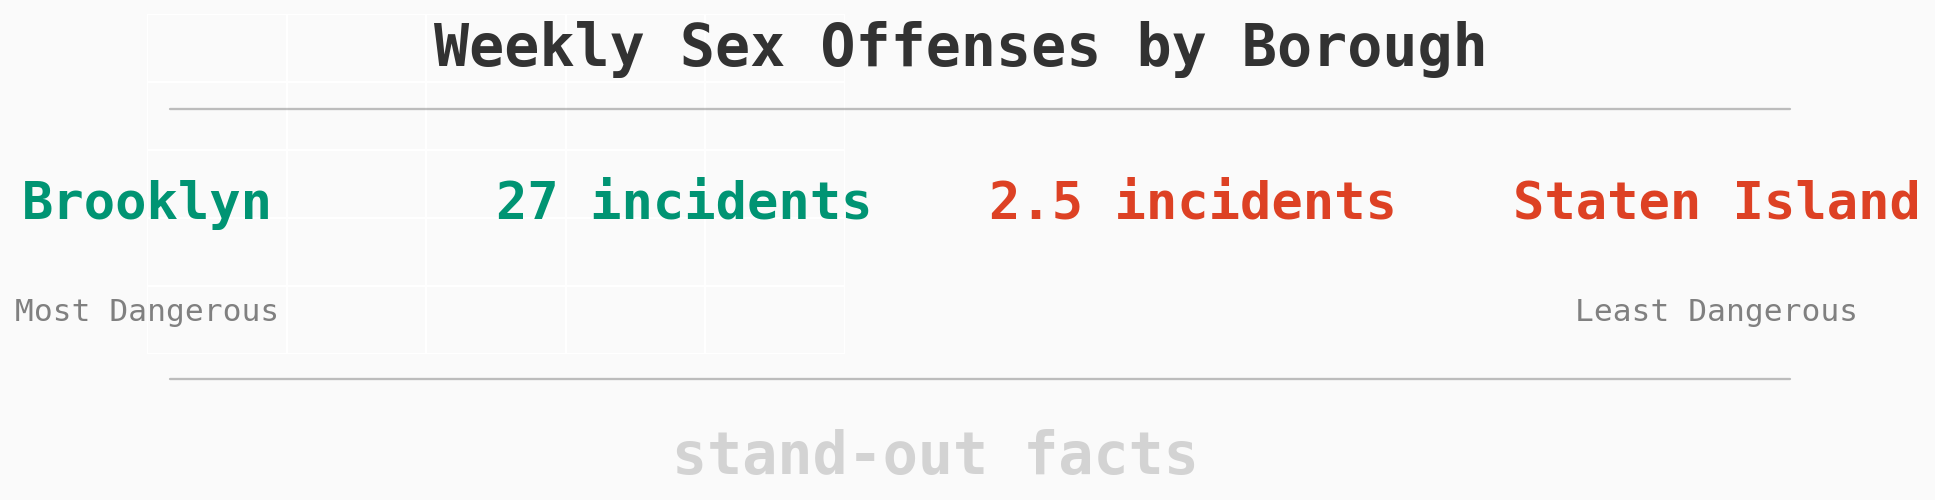

In [82]:
# inspiration ; https://www.kaggle.com/gaetanlopez/how-to-make-clean-visualizations
# changed code signif.

fig = plt.figure(figsize=(6,3),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(1.167,0.85,"Weekly Sex Offenses by Borough",color='#323232',fontsize=28, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(1.13,-0.35,"stand-out facts",color='lightgray',fontsize=28, fontweight='bold', fontfamily='monospace',ha='center')

ax0.text(0,0.4,"Brooklyn",color=high_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0,0.1,"Most Dangerous",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(0.77,0.4,"27 incidents",color=high_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
#ax0.text(0.75,0.1,"in Europe",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(1.5,0.4,"2.5 incidents",color=low_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
#ax0.text(1.5,0.1,"in Africa",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(2.25,0.4,"Staten Island",color=low_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(2.25,0.1,"Least Dangerous",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
import matplotlib.lines as lines
l1 = lines.Line2D([0.15, 1.95], [0.67, 0.67], transform=fig.transFigure, figure=fig,color = 'gray', linestyle='-',linewidth = 1.1, alpha = .5)
fig.lines.extend([l1])
l2 = lines.Line2D([0.15, 1.95], [0.07, 0.07], transform=fig.transFigure, figure=fig,color = 'gray', linestyle='-',linewidth = 1.1, alpha = .5)
fig.lines.extend([l2])
    
plt.show()

# Q2: Demographics. Who are the victims of sexula offenses?

Text(0.5, 4.5, '')

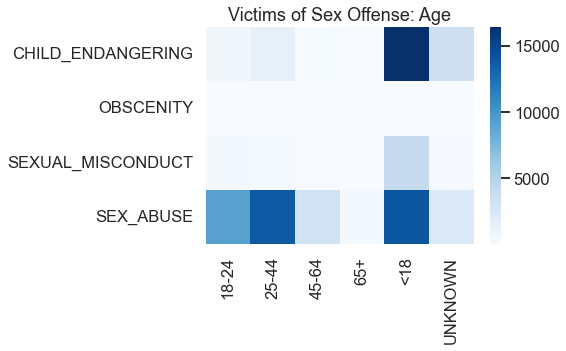

In [266]:
# Victim's Age

data = df_sex_offenses.groupby(['internal_desc', 'vic_age_group']).count().cmp_id.unstack()
sns.heatmap(data, cmap='Blues')
plt.title('Victims of Sex Offense: Age')
plt.ylabel('')
plt.xlabel('')

In [304]:
# Victim's Sex

data = df_sex_offenses.groupby(['internal_desc', 'vic_sex']).count().cmp_id.unstack()[['F', 'M']]
data.columns = ['Female', 'Male']
data.index = ['Child Endangering', 'Obscenity', 'Sexual Misconduct', 'Sexual Abuse']
data['Total Victims'] = data.Female + data.Male
data.index.name = 'Offense Type'
data = data.reset_index()
data

,Offense Type,Female,Male,Total Victims
0,Child Endangering,11992.0,8852.0,20844.0
1,Obscenity,72.0,13.0,85.0
2,Sexual Misconduct,4643.0,311.0,4954.0
3,Sexual Abuse,39263.0,3243.0,42506.0


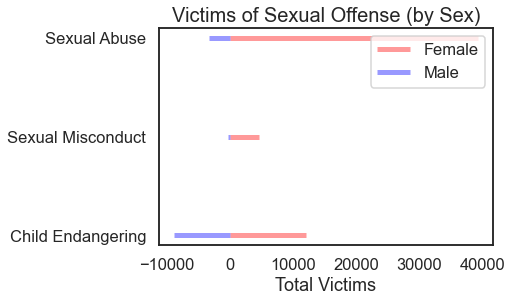

In [329]:
data = data[data['Offense Type'] != "Obscenity"]
plt.hlines(y=data['Offense Type'], xmin=0, xmax=data.Female,
           color='red', alpha=0.4, linewidth=5, label='Female')
plt.hlines(y=data['Offense Type'], xmin=-data.Male, xmax=0,
           color='blue', alpha=0.4, linewidth=5, label='Male')

# Decorations
# Setting the labels of x-axis and y-axis
plt.gca().set(ylabel='', xlabel='Total Victims')

# Setting Date to y-axis
#plt.yticks(df.index, df.Date, fontsize=12)

# Title of Bar Chart
plt.title('Victims of Sexual Offense (by Sex)', fontdict={'size': 20})
plt.legend()

In [ ]:
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [233]:
# Victim's Race

MAP_RACE = {
    'BLACK':'black',
    'WHITE': 'white',
    'ASIAN / PACIFIC ISLANDER': 'asian',
    'BLACK HISPANIC': 'hispanic',
    'WHITE HISPANIC': 'hispanic'
    }

df_cmp.vic_race = df_cmp.vic_race.map(MAP_RACE).fillna('UNKNOWN')
df_cmp.susp_race = df_cmp.vic_race.map(MAP_RACE).fillna('UNKNOWN')

data = df_sex_offenses.groupby(['internal_desc', 'vic_race']).count().cmp_id.unstack()
sns.heatmap(data.divide(data.sum(1), axis=0), cmap='Reds')
plt.title('Victims of Sex Offense: Race')
plt.ylabel('')
plt.xlabel('')

In [195]:
sex_crime_types_by_year = df_sex_offenses\
    .groupby([df_cmp.date_start.dt.year, 'internal_desc']).count().cmp_id\
    .loc['2006':,:]\
    .reset_index()\
    .rename(columns={'cmp_id':'total_offenses', 'date_start': 'year'})
sex_crime_types_by_year.head()

,year,internal_desc,total_offenses
0,2006,CHILD_ENDANGERING,1715
1,2006,OBSCENITY,11
2,2006,SEXUAL_MISCONDUCT,319
3,2006,SEX_ABUSE,2723
4,2007,CHILD_ENDANGERING,1377


Text(0.5, 1.0, 'Sexual offenses')

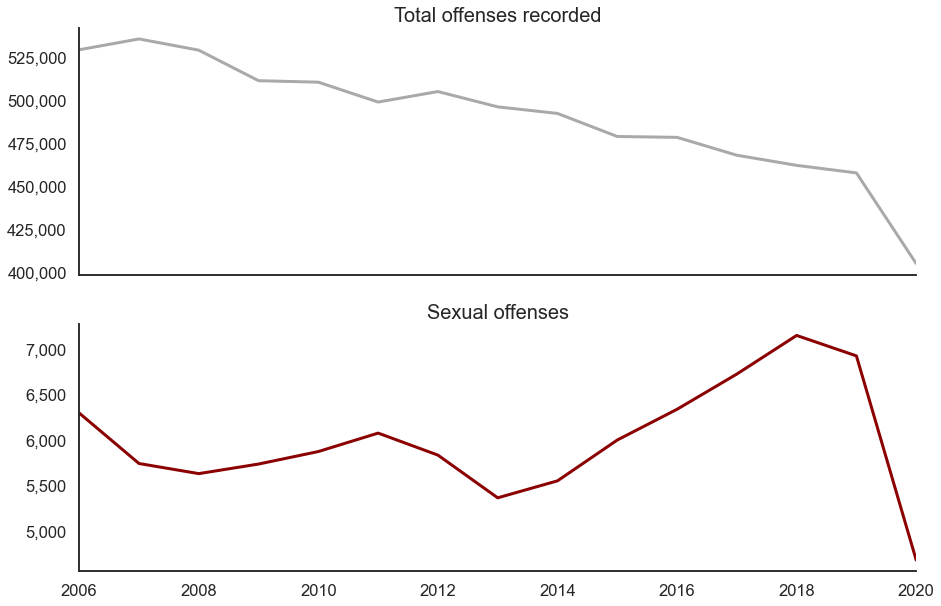

In [165]:
# plot
sns.set_context("talk")

fig, axs = plt.subplots(2,1, figsize=(15,10), sharex=True)
axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

crime_by_year.plot(lw=3, ax=axs[0],
                   markersize=15,
                   color='darkgrey',
                  )
sns.despine()
axs[0].set_title('Total offenses recorded', fontsize=20)
sex_crime_by_year.plot(lw=3, ax=axs[1],
                   markersize=15,
                   color='darkred',
                  )
sns.despine()
axs[1].set_xlabel('')
axs[1].set_title('Sexual offenses', fontsize=20)

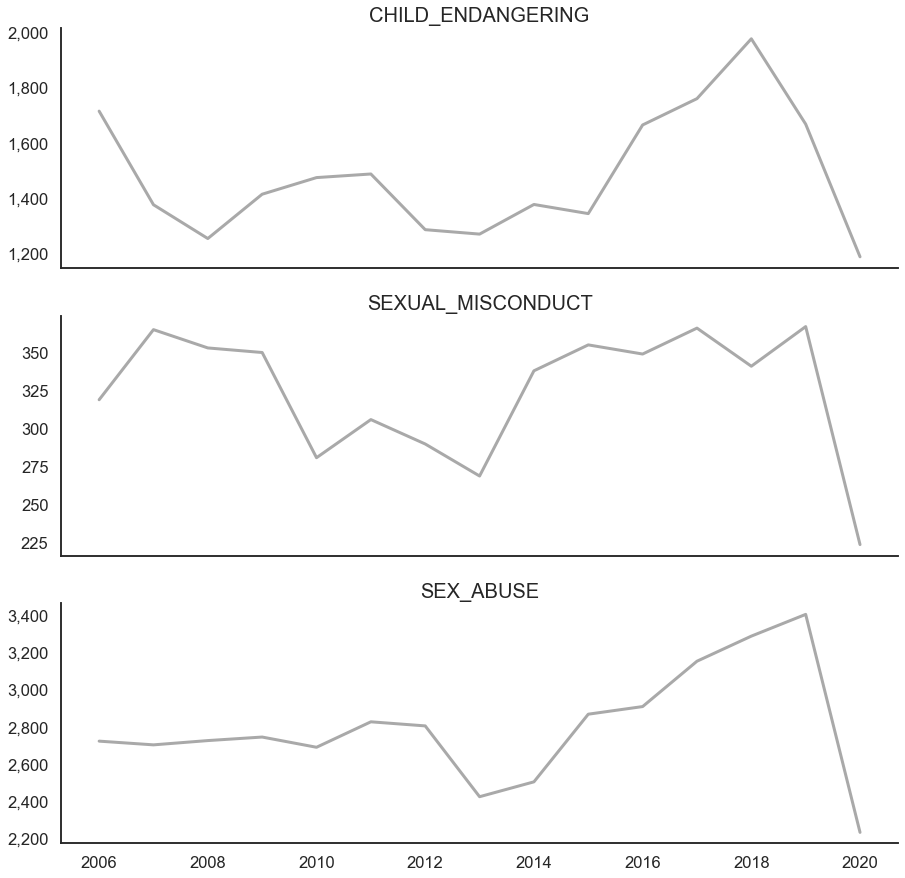

In [219]:
n_offenses = sex_crime_types_by_year.internal_desc.nunique() - 1

fig, axs = plt.subplots(n_offenses,1, figsize=(15,5*n_offenses), sharex=True)

for i, (offense_type, gr) in enumerate(sex_crime_types_by_year\
                                       .query('internal_desc != "OBSCENITY"')\
                                       .groupby('internal_desc')):
    axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    gr.set_index('year').total_offenses.plot(lw=3, ax=axs[i],color='darkgrey')
    sns.despine()
    axs[i].set_title(offense_type, fontsize=20)
    axs[i].set_xlabel('')

In [40]:
yearmonth = df_sex_offenses.groupby([df_sex_offenses.date_start.dt.year, df_sex_offenses.date_start.dt.month])\
    .count().cmp_id
yearmonth.index.names = ['year', 'month']
yearmonth = yearmonth.loc['2006':,:]

AttributeError: Can only use .dt accessor with datetimelike values

In [134]:
yearmonth = yearmonth.reset_index().rename(columns={'cmp_id':'total_offenses'})

Text(0.5, 1.0, 'Monthly offenses recorded (2006-2020)')

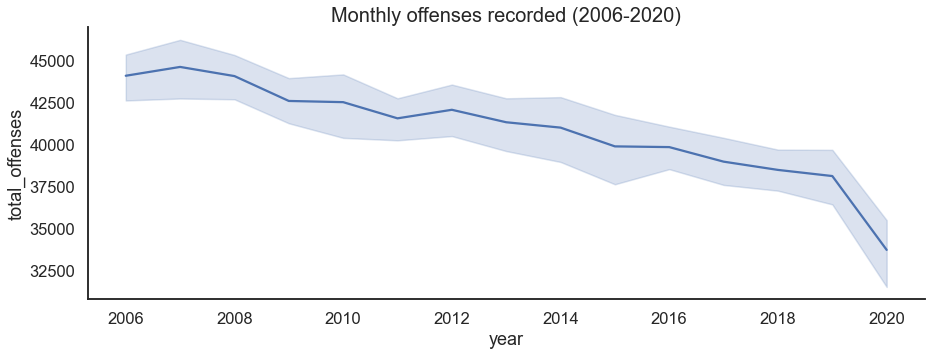

In [138]:
plt.figure(figsize=(15,5))
sns.lineplot(x="year", y="total_offenses",
             data=yearmonth)
sns.despine()
plt.title('Monthly offenses recorded (2006-2020)', fontsize=20)

In general, crime level has been going down steadily in the last 10 years.

Crime has very seasonal monthly patterns. Peak of crime occurs in the summer period (May to September), while the winter months experience the lowest crime levels.

# Q: How common is rape compared to other crimes?

In [405]:
df_cmp.offense_desc.nunique()

68

In [75]:
get_top_offenses(df_cmp)

['BURGLARY',
 'ROBBERY',
 'FELONY ASSAULT',
 'OFF. AGNST PUB ORD SENSBLTY &',
 'DANGEROUS DRUGS',
 'GRAND LARCENY',
 'CRIMINAL MISCHIEF & RELATED OF',
 'ASSAULT 3 & RELATED OFFENSES',
 'HARRASSMENT 2',
 'PETIT LARCENY']

Dataset contains 68 various offense types (key codes)

Text(0.5, 1.0, 'Percentage of all reported offenses (top 20)')

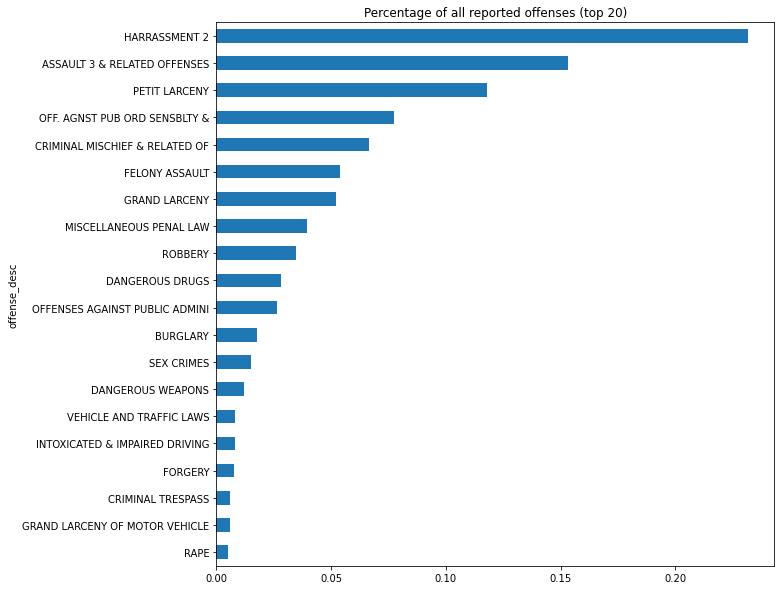

In [474]:
plt.figure(figsize=(10,10))
(df_cmp.groupby('offense_desc').count().cmp_id / df_cmp.shape[0]).sort_values().iloc[-20:]\
    .plot.barh()
plt.title('Percentage of all reported offenses (top 20)')

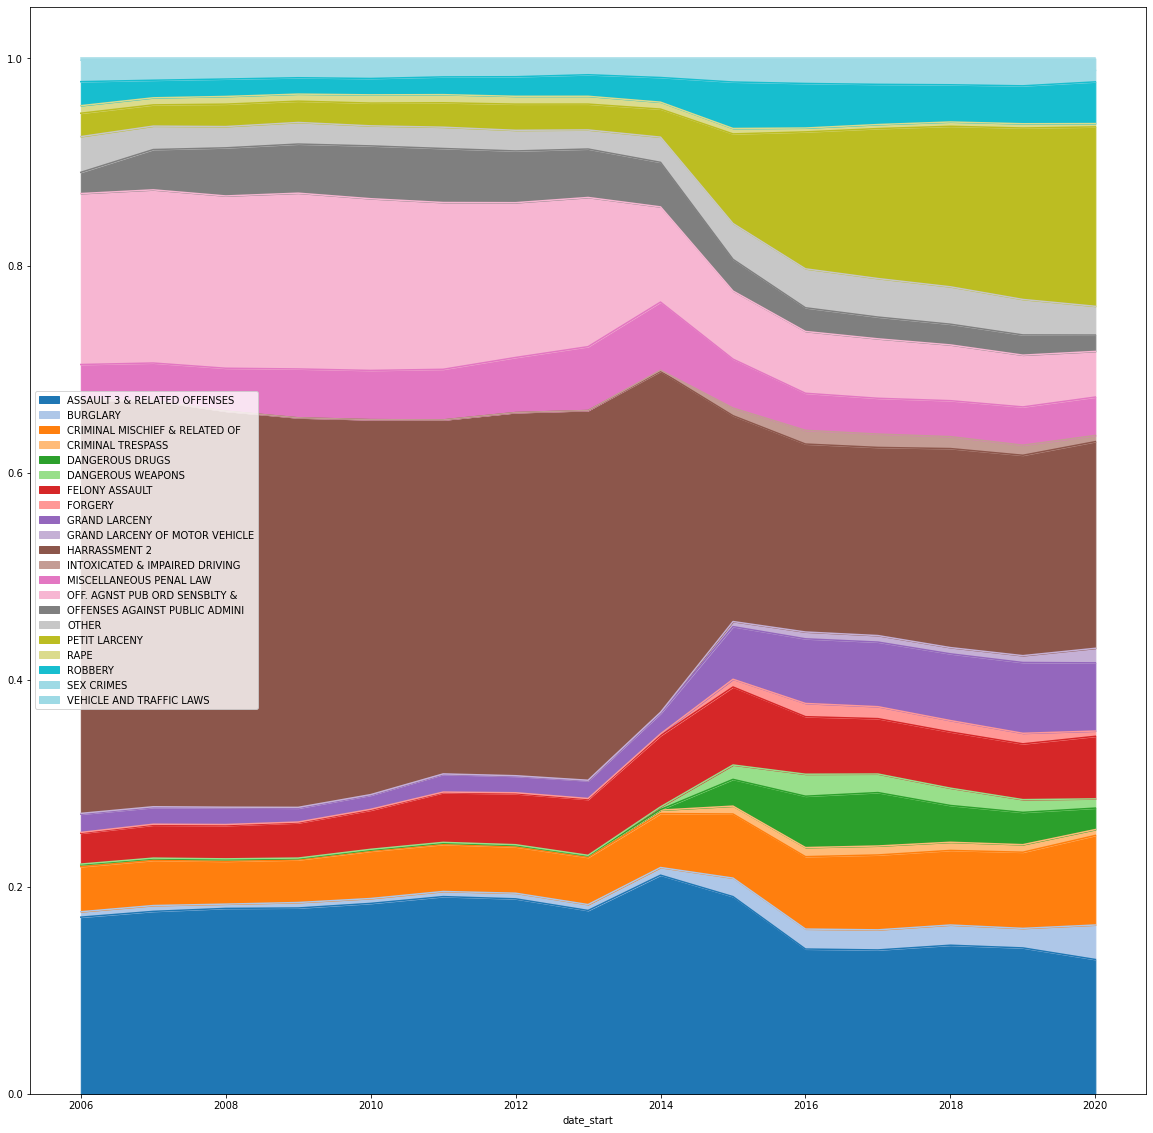

In [472]:
N_TOP_CRIMES = 20
top_crimes = df_cmp.groupby('offense_desc').count().cmp_id.sort_values().tail(N_TOP_CRIMES).index.tolist()

data = df_cmp.assign(offense_desc=df_cmp.offense_desc.apply(lambda of: of if of in top_crimes else 'OTHER'))\
    [(df_cmp.date_start.dt.year >= 2006)]\
    .groupby(['offense_desc', df_cmp.date_start.dt.year])\
    .count().cmp_id.unstack(0).fillna(0)

data.divide(data.sum(axis=1), axis=0).plot.area(figsize=(20,20), cmap=plt.get_cmap('tab20'))
plt.legend(loc='best')

* By 2015, percentage of **harassement** (2nd degree) has halved
* Offenses like **posession of drugs** and **dangerous weapons** are becomning more prominent since 2013
* **Offenses against public sensibility** are becoming less relevant (public is less sensitive?)
* No significant changes for **felony assault** and **criminal mischief** over the years
* **Grand and petit larceny** are having a sharp rise from 2014/2015
* Percentage of **sex crimes** remains quite stable throughout the years

## Q: Seasonality

In [88]:
top_offenses = get_top_offenses(df_cmp, 10)

plt.figure(figsize=(16,16))
data = df_cmp[df_cmp.offense_desc.isin([*top_offenses, *SEX_OFFENSES])]\
    .groupby(['offense_desc', df_cmp.date_start.dt.weekday])\
    .count().cmp_id.unstack().fillna(0).T

<Figure size 1152x1152 with 0 Axes>

In [86]:
data

offense_desc,ASSAULT 3 & RELATED OFFENSES,BURGLARY,CRIMINAL MISCHIEF & RELATED OF,CRIMINAL TRESPASS,DANGEROUS DRUGS,DANGEROUS WEAPONS,FELONY ASSAULT,FORGERY,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,HARRASSMENT 2,INTOXICATED & IMPAIRED DRIVING,MISCELLANEOUS PENAL LAW,OFF. AGNST PUB ORD SENSBLTY &,OFFENSES AGAINST PUBLIC ADMINI,PETIT LARCENY,ROBBERY,SEX CRIMES,THEFT-FRAUD,VEHICLE AND TRAFFIC LAWS
date_start,,,,,,,,,,,,,,,,,,,,
0,104504,38134,101425,9175,33741,14067,37699,8068,93201,19279,137928,8557,24079,59680,16946,179538,39369,10009,13425,12265
1,101434,37086,103371,12933,70596,23987,36533,12274,91669,18622,137985,6542,27121,57545,19339,182676,38184,10391,12320,13042
2,103159,38791,104695,13792,78566,27207,36636,13039,92986,18705,139252,8364,28285,57026,20644,185323,37868,10413,12146,13283
3,102483,38052,104377,13137,75010,26722,36315,12548,92863,18867,136653,9632,28080,55534,20164,181092,37153,10500,12086,13649
4,110508,45160,116030,13417,74346,27966,39546,11612,103316,20757,139358,14419,28334,55530,21062,192158,39412,10693,12407,14303
5,123698,31308,111978,11361,61488,25326,48911,9038,88703,19247,126952,25804,27126,48569,20712,171176,37683,9249,8009,13340
6,128419,25730,102987,8324,33322,16176,50494,6130,76144,18345,127237,23067,24787,49433,18649,152074,36759,8965,6245,11919


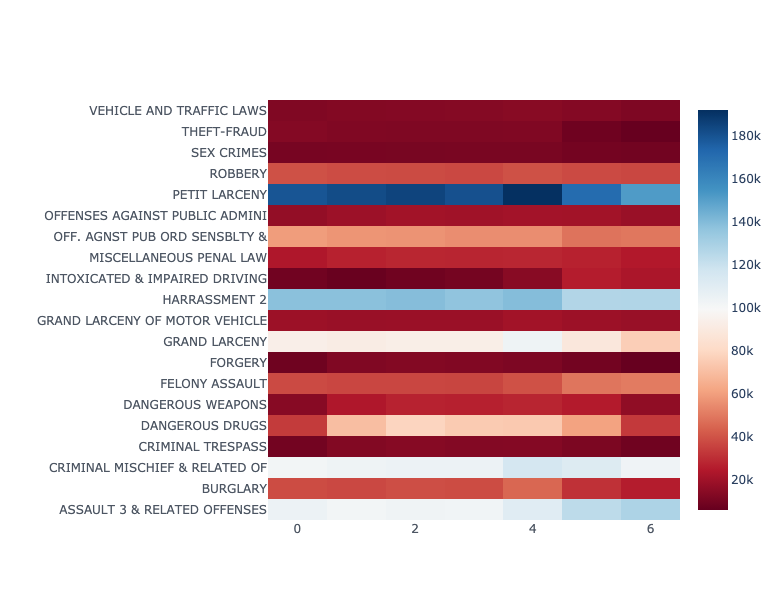

In [84]:
data.T.iplot(kind="heatmap",
           colorscale="rdbu",
           dimensions=(700,600))
#sns.heatmap(data.divide(data.sum(axis=1), axis=0), cmap='coolwarm', vmax=0.17, vmin=0.12)

In [626]:
df_sex_crimes = df_cmp.query('offense_desc == "SEX CRIMES"')

<AxesSubplot:xlabel='date_start', ylabel='internal_desc'>

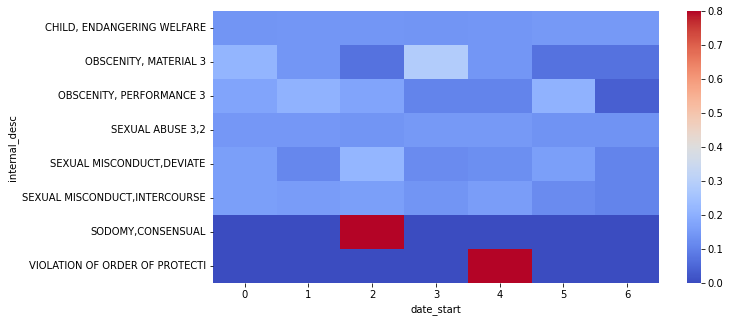

In [629]:
plt.figure(figsize=(10,5))
data = df_sex_crimes\
    .groupby(['internal_desc', df_sex_crimes.date_start.dt.weekday])\
    .count().cmp_id.unstack().fillna(0)
sns.heatmap(data.divide(data.sum(axis=1), axis=0), cmap='coolwarm', vmax=0.8)

In [639]:
df_sex_crimes = df_sex_crimes[~df_sex_crimes.internal_desc\
                              .isin(('VIOLATION OF ORDER OF PROTECTI', 'SODOMY,CONSENSUAL'))]

In [634]:
# one case was misclassified to a close category
print(df_cmp.query('internal_desc == "RAPE 1"').offense_desc.value_counts())

df_cmp.loc[df_cmp.internal_desc == "RAPE 1", 'offense_desc'] = 'RAPE'
df_cmp.loc[df_cmp.internal_desc == "RAPE 1", 'key_code'] = 104

RAPE    8021
Name: offense_desc, dtype: int64


<AxesSubplot:xlabel='date_start', ylabel='internal_desc'>

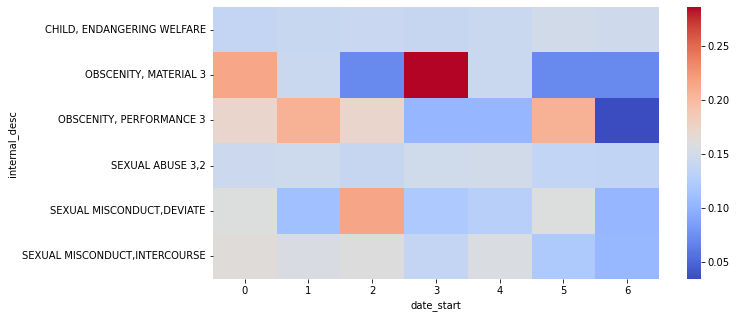

In [646]:
plt.figure(figsize=(10,5))
data = df_sex_crimes\
    .groupby(['internal_desc', df_sex_crimes.date_start.dt.weekday])\
    .count().cmp_id.unstack().fillna(0)
sns.heatmap(data.divide(data.sum(axis=1), axis=0), cmap='coolwarm')

## Hour of the day

In [671]:
df_cmp['hour_start'] = df_cmp.time_start.apply(lambda t: t.hour)

Text(0.5, 1.0, 'Sex crimes by the weekday and hour of the day')

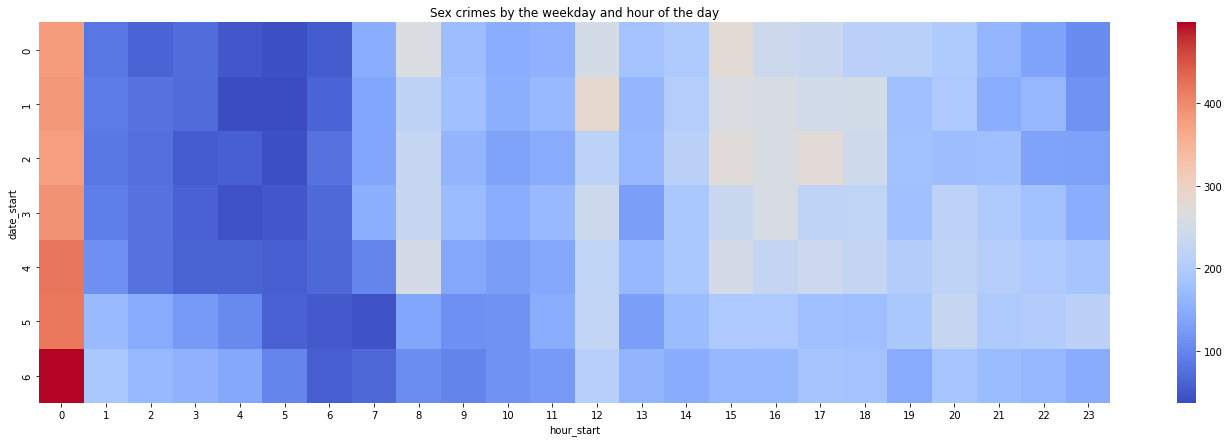

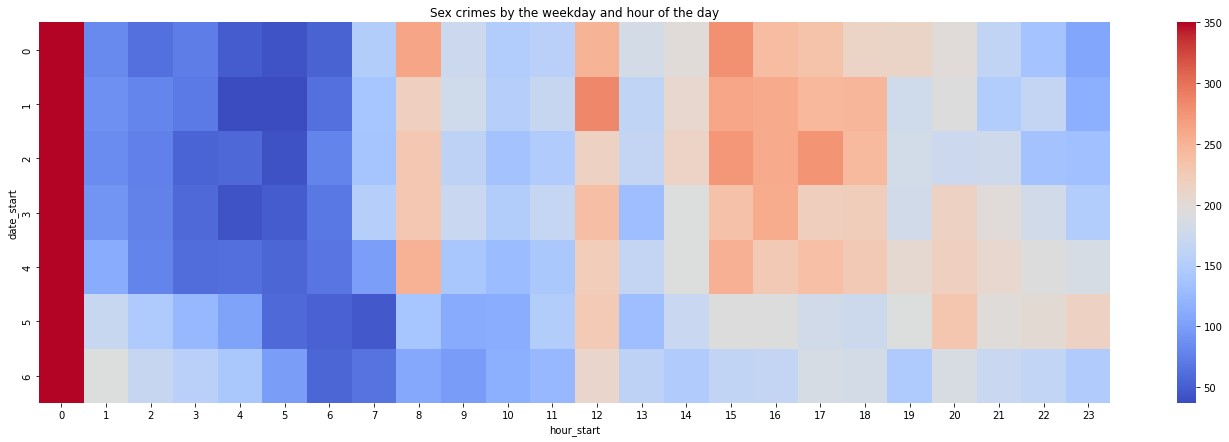

In [672]:
plt.figure(figsize=(24,7))
sns.heatmap(df_sex_crimes.groupby([df_sex_crimes.date_start.dt.weekday, 'hour_start'])\
            .count().cmp_id.unstack(),
           cmap='coolwarm')
plt.title('Sex crimes by the weekday and hour of the day')

plt.figure(figsize=(24,7))
sns.heatmap(df_sex_crimes.groupby([df_sex_crimes.date_start.dt.weekday, 'hour_start'])\
            .count().cmp_id.unstack(),
           cmap='coolwarm', vmax=350)
plt.title('Sex crimes by the weekday and hour of the day')

Text(0.5, 1.0, 'Rapes by the weekday and hour of the day')

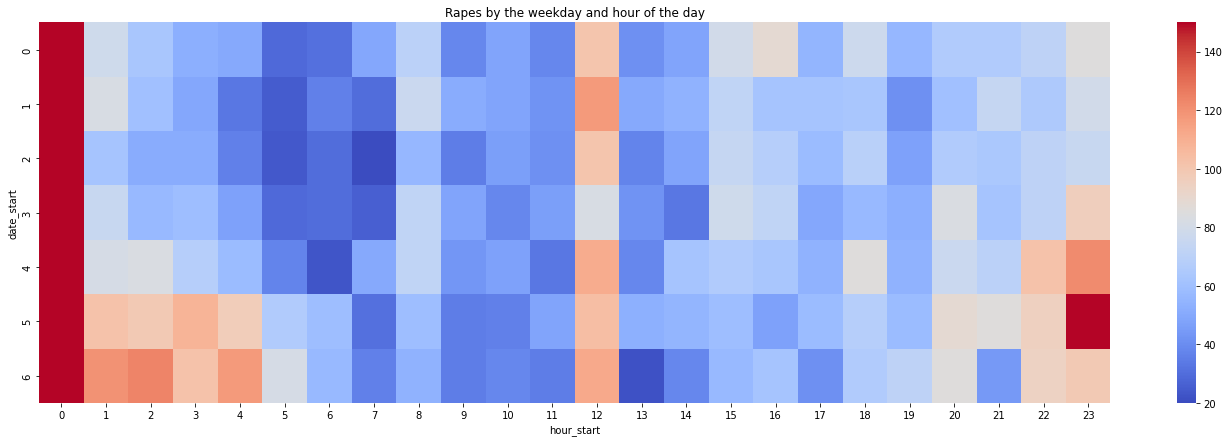

In [738]:
plt.figure(figsize=(24,7))
sns.heatmap(df_cmp.query('offense_desc == "RAPE"')\
            .groupby([df_cmp.date_start.dt.weekday, 'hour_start'])\
            .count().cmp_id.unstack(),
           cmap='coolwarm', vmax=150)
plt.title('Rapes by the weekday and hour of the day')

This looks like an entry error dur to confusing midnight (0:00) and noon (12:00).

In [689]:
df_cmp.query('offense_desc == "RAPE" and hour_start == 12')

,cmp_id,date_start,time_start,date_end,time_end,loc_precinct,date_reported,key_code,offense_desc,internal_code,...,long,Lat_Lon,loc_borough_patrol,loc_transit_station,vic_age_group,vic_race,vic_sex,crime_till_report,duration_days,hour_start
31426,347161540,2017-02-14,12:00:00,2017-02-14,14:00:00,69.0,2019-12-05,104,RAPE,157.0,...,-73.904897,"(40.64842111900003, -73.90489710899999)",PATROL BORO BKLYN SOUTH,NaN,18-24,BLACK,F,1024,0.0,12
32161,887092883,2017-10-20,12:00:00,NaT,NaN,47.0,2019-12-10,104,RAPE,153.0,...,-73.847608,"(40.88745131300004, -73.84760778699997)",PATROL BORO BRONX,NaN,45-64,BLACK,F,781,NaN,12
53351,469198976,2012-01-01,12:00:00,2012-12-31,12:00:00,79.0,2019-11-20,104,RAPE,157.0,...,-73.944529,"(40.688872153000034, -73.94452903199993)",PATROL BORO BKLYN NORTH,NaN,<18,WHITE HISPANIC,F,2880,365.0,12
59332,452130663,2017-01-01,12:00:00,2017-12-31,12:00:00,113.0,2019-11-21,104,RAPE,155.0,...,-73.776047,"(40.67970040800003, -73.77604736799998)",PATROL BORO QUEENS SOUTH,NaN,<18,ASIAN / PACIFIC ISLANDER,F,1054,364.0,12
64195,933135381,2019-09-10,12:00:00,NaT,NaN,66.0,2019-11-03,104,RAPE,153.0,...,-73.991417,"(40.62576896100006, -73.99141682199996)",PATROL BORO BKLYN SOUTH,NaN,<18,WHITE HISPANIC,F,54,NaN,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7348751,142298169,2017-09-05,12:00:00,2017-09-05,23:59:00,71.0,2018-11-15,104,RAPE,155.0,...,-73.947739,"(40.664527498, -73.947739291)",PATROL BORO BKLYN SOUTH,NaN,<18,BLACK,F,436,0.0,12
7365045,633970904,2017-09-01,12:00:00,2017-09-06,17:00:00,76.0,2018-04-17,104,RAPE,159.0,...,-74.000326,"(40.683879057, -74.000325948)",PATROL BORO BKLYN SOUTH,NaN,<18,BLACK,F,228,5.0,12
7366644,713735856,2018-03-14,12:00:00,NaT,NaN,45.0,2018-03-14,104,RAPE,157.0,...,-73.827285,"(40.830889993, -73.82728462)",PATROL BORO BRONX,NaN,45-64,WHITE HISPANIC,F,0,NaN,12
7374181,653179834,2018-06-19,12:00:00,2018-06-19,12:30:00,110.0,2018-10-12,104,RAPE,155.0,...,-73.870063,"(40.745252741, -73.87006287)",PATROL BORO QUEENS NORTH,NaN,<18,BLACK HISPANIC,F,115,0.0,12


Text(0.5, 1.0, 'Sex crimes by the weekday and hour of the day')

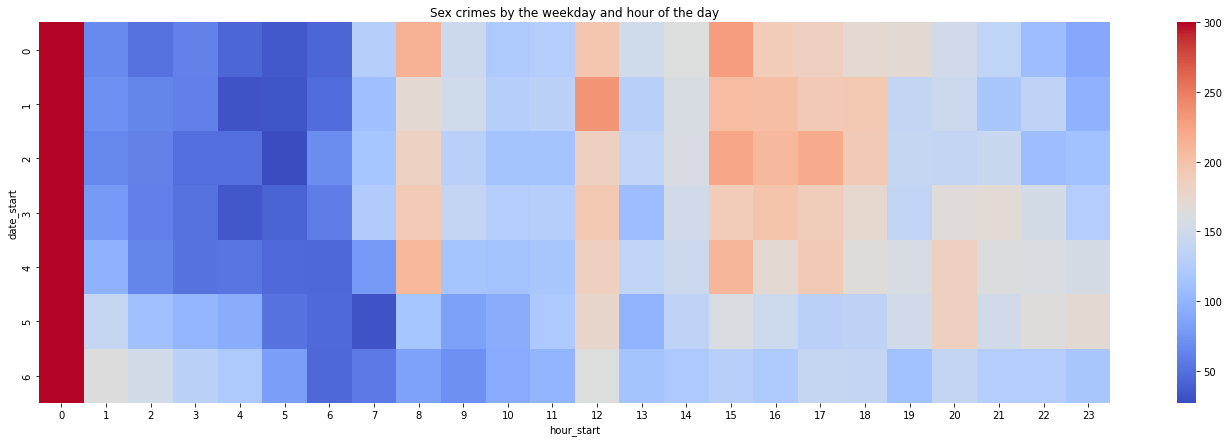

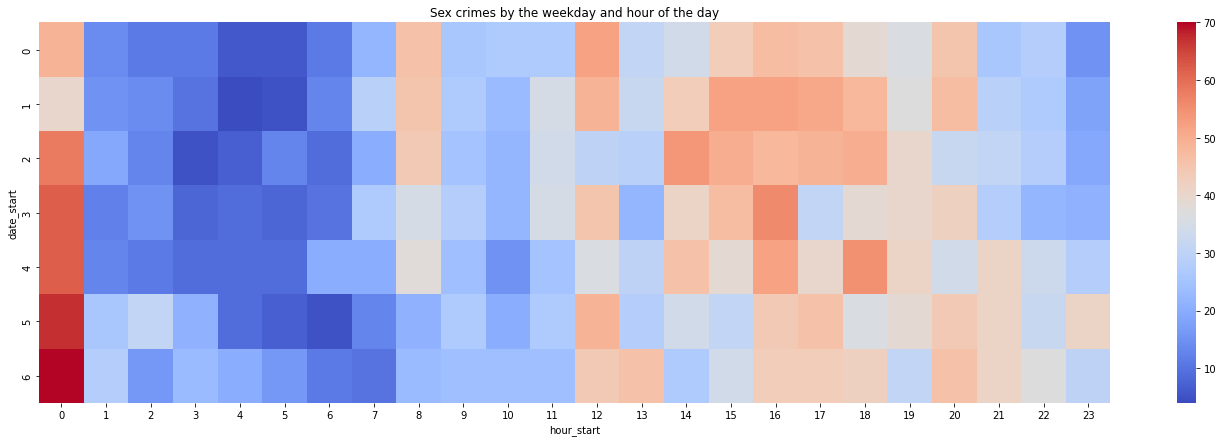

In [735]:
plt.figure(figsize=(24,7))
sns.heatmap(df_sex_crimes.query('vic_sex == "F"')\
            .groupby([df_sex_crimes.date_start.dt.weekday, 'hour_start'])\
            .count().cmp_id.unstack(),
           cmap='coolwarm', vmax=300)
plt.title('Sex crimes by the weekday and hour of the day')

plt.figure(figsize=(24,7))
sns.heatmap(df_sex_crimes.query('vic_sex == "M"')\
            .groupby([df_sex_crimes.date_start.dt.weekday, 'hour_start'])\
            .count().cmp_id.unstack(),
           cmap='coolwarm')
plt.title('Sex crimes by the weekday and hour of the day')

## Location

In [757]:
data_loc = df_sex_crimes[df_sex_crimes.vic_sex.isin(('F','M'))]

<AxesSubplot:ylabel='loc_premises'>

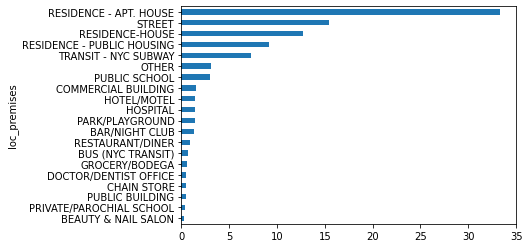

In [759]:
(data_loc.groupby('loc_premises').count().cmp_id.sort_values().tail(20) / data_loc.shape[0] * 100)\
    .plot.barh()

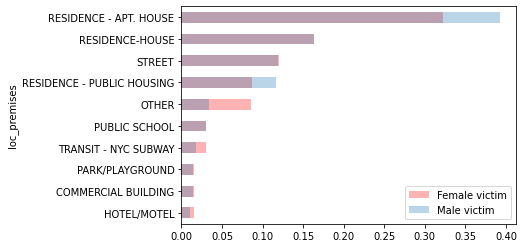

In [777]:
data = data_loc.groupby(['loc_premises', 'vic_sex']).count().cmp_id.unstack(0).fillna(0)
data = data.divide(data.sum(axis=1), axis=0).T

data.sort_values(by='F').tail(10).F.plot.barh(alpha=0.3, color='red', label='Female victim')
data.sort_values(by='M').tail(10).M.plot.barh(alpha=0.3, label='Male victim')

plt.legend()

In [801]:
data = data_loc.groupby(['loc_premises', 'vic_age_group']).count().cmp_id.unstack().fillna(0).T
data = data.divide(data.sum(axis=1), axis=0).T
data

vic_age_group,18-24,25-44,45-64,65+,<18,UNKNOWN
loc_premises,,,,,,
ABANDONED BUILDING,0.000249,0.000146,0.000000,0.000000,0.000143,0.000000
AIRPORT TERMINAL,0.000994,0.001753,0.000664,0.000000,0.000358,0.002618
BANK,0.001243,0.001169,0.000664,0.000000,0.000286,0.000873
BAR/NIGHT CLUB,0.027336,0.029652,0.007304,0.005236,0.000859,0.012216
BEAUTY & NAIL SALON,0.005964,0.005112,0.002656,0.000000,0.001002,0.005236
...,...,...,...,...,...,...
TRANSIT - NYC SUBWAY,0.125497,0.141543,0.108234,0.036649,0.023038,0.058464
TRANSIT FACILITY (OTHER),0.002485,0.001169,0.003320,0.000000,0.000286,0.001745
TUNNEL,0.000497,0.000146,0.000000,0.000000,0.000215,0.000000


In [817]:
top_loc = data.sort_values(by='18-24').tail(20).index
data.index = data.index.map(lambda l: l if l in top_loc else 'OTHER')
data = data.groupby(level=0).sum()
data

vic_age_group,18-24,25-44,45-64,65+,<18,UNKNOWN
loc_premises,,,,,,
BAR/NIGHT CLUB,0.027336,0.029652,0.007304,0.005236,0.000859,0.012216
BEAUTY & NAIL SALON,0.005964,0.005112,0.002656,0.000000,0.001002,0.005236
BUS (NYC TRANSIT),0.007704,0.006573,0.009960,0.000000,0.006797,0.002618
CHAIN STORE,0.007207,0.007304,0.003984,0.005236,0.003363,0.001745
COMMERCIAL BUILDING,0.017147,0.027023,0.029880,0.031414,0.007369,0.013962
DEPARTMENT STORE,0.004970,0.002337,0.002656,0.005236,0.001574,0.001745
DOCTOR/DENTIST OFFICE,0.004970,0.007450,0.030544,0.020942,0.000715,0.006108
GROCERY/BODEGA,0.007455,0.005989,0.009296,0.005236,0.004722,0.003490
HOSPITAL,0.015656,0.022349,0.058433,0.099476,0.003720,0.012216


<AxesSubplot:xlabel='vic_age_group', ylabel='loc_premises'>

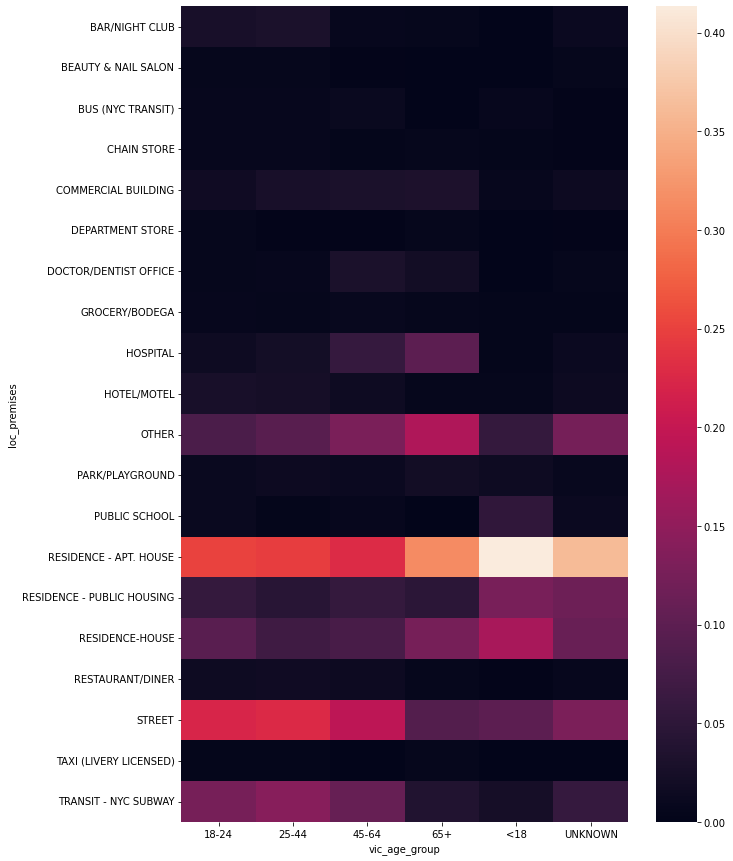

In [821]:
plt.figure(figsize=(10,15))
sns.heatmap(data)

Are rapes happening inside residences reported later?

In [853]:
data = df_sex_crimes.groupby('loc_premises').agg({'cmp_id': 'count', 'crime_till_report': np.mean})
data.sort_values(by='cmp_id').tail(10)

,cmp_id,crime_till_report
loc_premises,,
HOSPITAL,392,70.862245
HOTEL/MOTEL,396,192.156566
COMMERCIAL BUILDING,427,208.199063
PUBLIC SCHOOL,829,75.613993
OTHER,887,147.355130
TRANSIT - NYC SUBWAY,2078,4.914822
RESIDENCE - PUBLIC HOUSING,2569,141.833787
RESIDENCE-HOUSE,3553,263.323670
STREET,4375,15.850057


In [868]:
df_sex_crimes.groupby('loc_borough').count().cmp_id / df_cmp.groupby('loc_borough').count().cmp_id

loc_borough
BRONX            0.010143
BROOKLYN         0.010650
MANHATTAN        0.012946
QUEENS           0.013078
STATEN ISLAND    0.009828
Name: cmp_id, dtype: float64

In [873]:
df_cmp.groupby(['loc_borough', 'loc_premises']).count().cmp_id.unstack().T.tail(20)

loc_borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
loc_premises,,,,,
RESIDENCE - PUBLIC HOUSING,58641.0,76797.0,69114.0,19191.0,6821.0
RESIDENCE-HOUSE,38201.0,86097.0,3346.0,125908.0,45515.0
RESTAURANT/DINER,2687.0,5743.0,12209.0,4295.0,842.0
SHOE,139.0,253.0,753.0,183.0,30.0
SMALL MERCHANT,1017.0,1900.0,2288.0,1403.0,207.0
SOCIAL CLUB/POLICY,198.0,477.0,295.0,271.0,39.0
STORAGE FACILITY,497.0,483.0,212.0,341.0,44.0
STORE UNCLASSIFIED,1458.0,2306.0,1657.0,1897.0,287.0
STREET,142514.0,174096.0,123428.0,115211.0,19801.0


## Are you more likely to be raped on the street than at home?

# Q: How much time passes till sex crimes are reported?

In [309]:
df_cmp['crime_till_report'] = (df_cmp.date_reported - df_cmp.date_start).dt.days

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_4362/2586576069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cmp['crime_till_report'] = (df_cmp.date_reported - df_cmp.date_start).dt.days


In [310]:
# in some cases it loooks like crime was reported before it happened. Most likely dur to incorrect data entry
df_cmp[df_cmp.crime_till_report < 0]

,cmp_id,date_start,time_start,date_end,time_end,loc_precinct,date_reported,key_code,offense_desc,internal_code,...,transit_district,lat,long,Lat_Lon,loc_borough_patrol,loc_transit_station,vic_age_group,vic_race,vic_sex,crime_till_report


In [311]:
# let's remove rows with impossible report date
df_cmp = df_cmp[df_cmp.crime_till_report >= 0]

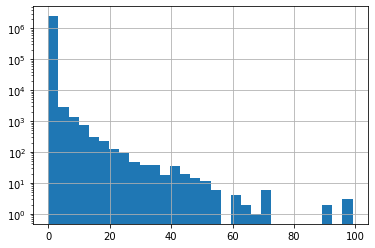

In [386]:
(df_cmp[(df_cmp.crime_till_report <= 100*365)].crime_till_report/365).hist(bins=30)
plt.yscale('log')

In [398]:
df_cmp[df_cmp.offense_desc=='ABORTION']

,cmp_id,date_start,time_start,date_end,time_end,loc_precinct,date_reported,key_code,offense_desc,internal_code,...,transit_district,lat,long,Lat_Lon,loc_borough_patrol,loc_transit_station,vic_age_group,vic_race,vic_sex,crime_till_report
1462065,511814999,2017-10-09,12:00:00,2017-10-12,10:00:00,114.0,2017-11-09,123,ABORTION,143.0,...,NaN,40.754933,-73.910390,"(40.754933481, -73.910390193)",PATROL BORO QUEENS NORTH,NaN,25-44,WHITE HISPANIC,F,31
2983185,975101365,2015-02-06,19:00:00,2015-02-06,19:30:00,106.0,2015-06-29,123,ABORTION,143.0,...,NaN,40.681569,-73.843618,"(40.681568742, -73.843618316)",PATROL BORO QUEENS SOUTH,NaN,25-44,ASIAN / PACIFIC ISLANDER,F,143
6787352,494481115,2015-08-24,21:25:00,2015-08-24,21:35:00,101.0,2015-08-24,123,ABORTION,143.0,...,NaN,40.602226,-73.754689,"(40.602226139, -73.754689329)",PATROL BORO QUEENS SOUTH,NaN,18-24,BLACK,F,0
7119271,721831260,2018-04-20,23:00:00,NaT,NaN,46.0,2018-05-08,123,ABORTION,143.0,...,NaN,40.854989,-73.899968,"(40.854989406, -73.899967505)",PATROL BORO BRONX,NaN,25-44,WHITE HISPANIC,F,18


Text(0.5, 1.0, 'Time passed before the crime is reported (in months)')

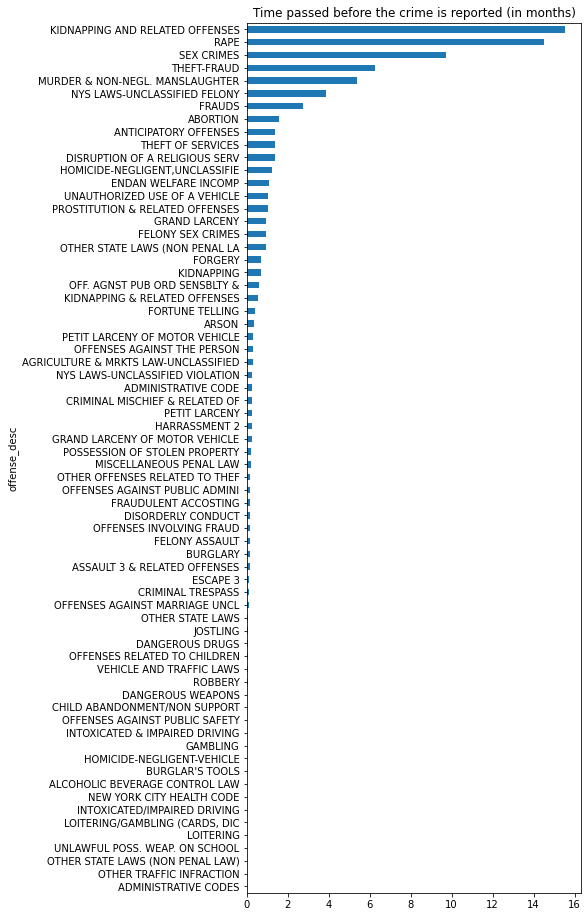

In [399]:
plt.figure(figsize=(6,16))
(df_cmp.groupby('offense_desc').crime_till_report.mean().sort_values()/30).plot.barh()
plt.title('Time passed before the crime is reported (in months)')

We see there outliers with a very high gap between incident and report dates. This skews our results.


<AxesSubplot:>

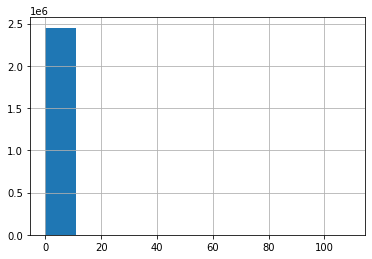

In [313]:
# in some cases, over 10 years passes between the incidence and the report. Let\s focus on those cases
(df_cmp.crime_till_report /365).hist()

In [314]:
df_late_report = df_cmp[df_cmp.crime_till_report > 10 * 365]
print(f'Out of {df_cmp.shape[0]:,} crimes reported between 2006 and 2021, {df_late_report.shape[0]} have occured at least 10 years ago')

Out of 2,452,474 crimes reported between 2006 and 2021, 1763 have occured at least 10 years ago


<AxesSubplot:>

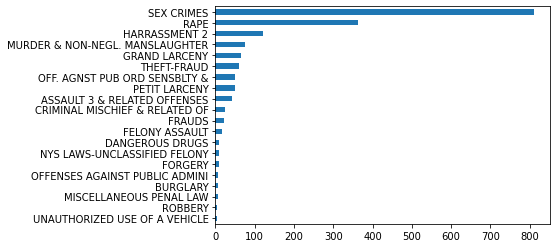

In [315]:
df_late_report.offense_desc.value_counts().head(20).sort_values().plot.barh()

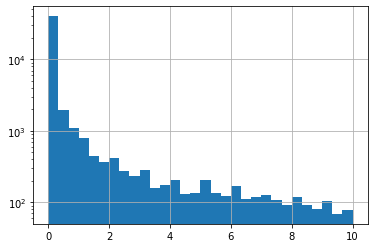

In [385]:
(df_cmp[(df_cmp.crime_till_report <= 10*365)\
       & (df_cmp.offense_desc.isin(('SEX CRIMES', 'RAPE')))].crime_till_report/365).hist(bins=30)
plt.yscale('log')

Sex related crimes are at the top of the list! Second beggest group of offenses are theft & fraud related crimes.

Let's take a closer look at sex offenses.

In [395]:
is_sex_crime = df_late_report.offense_desc.isin(('SEX CRIMES', 'RAPE', 'FELONY SEX CRIMES'))

Text(0.5, 1.0, 'Sex crimes reports with 10+ years delay since 2006 (NYC)')

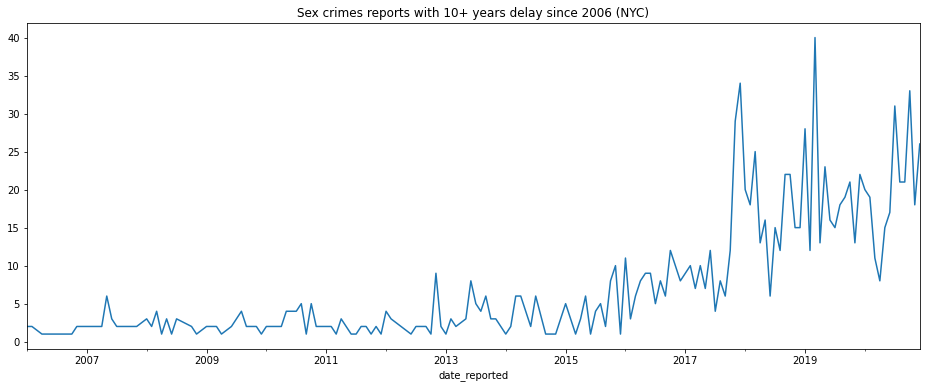

In [396]:
plt.figure(figsize=(16,6))
sex_crimes_reports = df_late_report[is_sex_crime]\
    .groupby(df_late_report.date_reported.dt.to_period('M')).count().cmp_id
sex_crimes_reports.plot()
plt.title('Sex crimes reports with 10+ years delay since 2006 (NYC)')

There is a big spike at the end of 2017. Could that be the correlated with the start of the Me Too movement?

<AxesSubplot:>

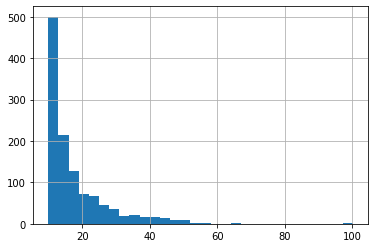

In [373]:
(df_late_report[is_sex_crime].crime_till_report/365)\
    .hist(bins=30)

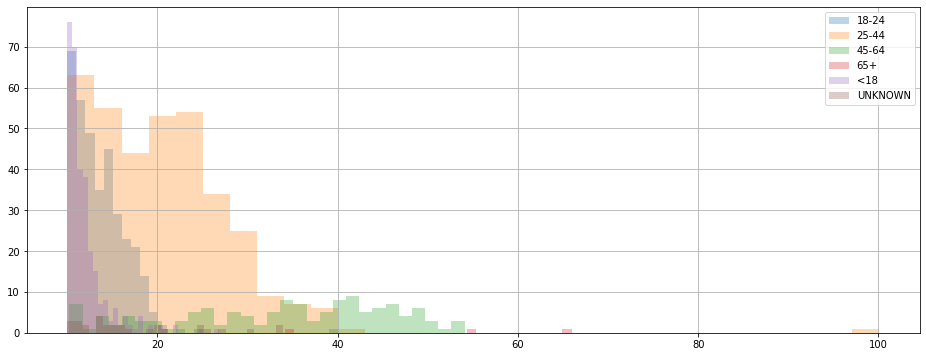

In [374]:
plt.figure(figsize=(16,6))
for name, gr in df_late_report[is_sex_crime]\
    .groupby('vic_age_group'):
    (gr.crime_till_report/365).hist(label=name, alpha=0.3, bins=30)
plt.legend()

<AxesSubplot:xlabel='vic_age_group', ylabel='susp_age_group'>

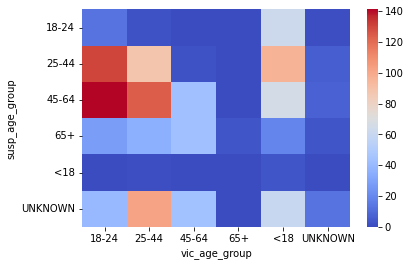

In [ ]:
sns.heatmap(df_late_report[is_sex_crime]\
    .groupby(['susp_age_group', 'vic_age_group']).count().cmp_id.unstack().fillna(0),\
           cmap='coolwarm')

<AxesSubplot:xlabel='vic_sex', ylabel='susp_sex'>

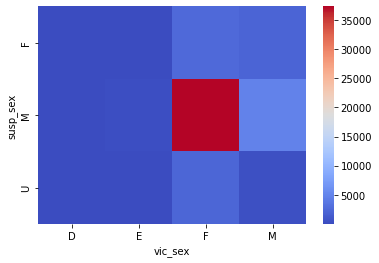

In [377]:
sns.heatmap(df_cmp[df_cmp.offense_desc.isin(('SEX CRIMES', 'RAPE'))]\
    .groupby(['susp_sex', 'vic_sex']).count().cmp_id.unstack().fillna(0),\
           cmap='coolwarm')

<AxesSubplot:xlabel='vic_race', ylabel='susp_race'>

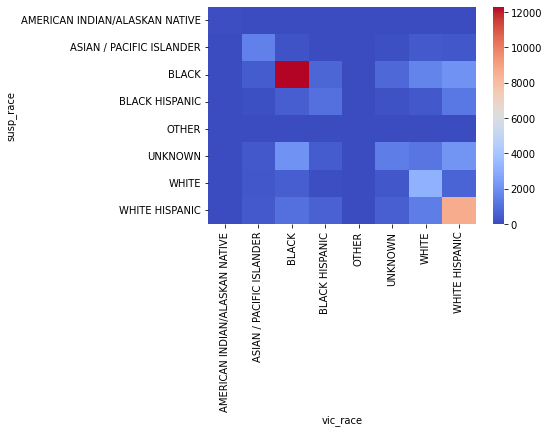

In [338]:
sns.heatmap(df_cmp[df_cmp.offense_desc.isin(('SEX CRIMES', 'RAPE'))]\
    .groupby(['susp_race', 'vic_race']).count().cmp_id.unstack().fillna(0),\
           cmap='coolwarm')

<AxesSubplot:xlabel='vic_age_group', ylabel='susp_age_group'>

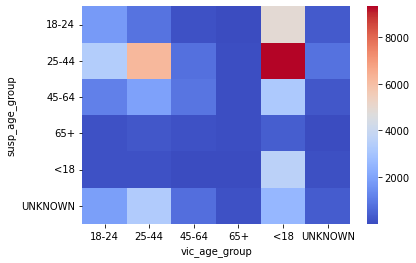

In [320]:
sns.heatmap(df_cmp[df_cmp.offense_desc.isin(('SEX CRIMES', 'RAPE'))]\
    .groupby(['susp_age_group', 'vic_age_group']).count().cmp_id.unstack().fillna(0),\
           cmap='coolwarm')

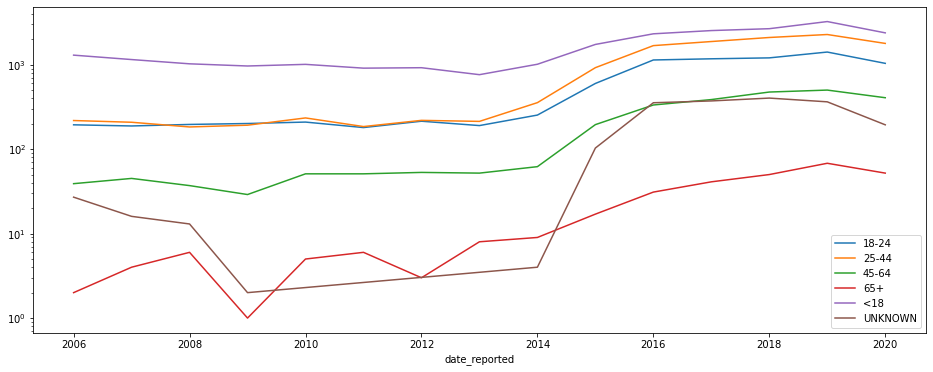

In [330]:
plt.figure(figsize=(16,6))
for name, gr in df_cmp[df_cmp.offense_desc.isin(('SEX CRIMES', 'RAPE'))]\
    .groupby(['vic_age_group']):
    gr.groupby(df_cmp.date_reported.dt.year).count().cmp_id\
    .plot(label=name)
plt.legend()
plt.yscale('log')

Text(0.5, 1.0, 'Average delay between the report and the crime (in months)')

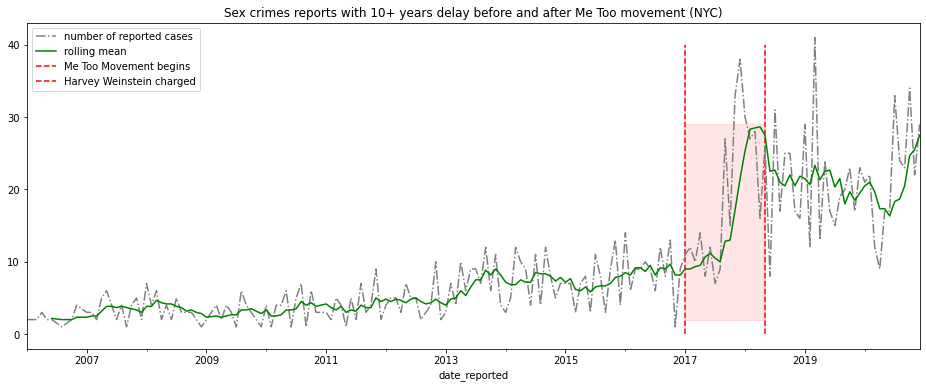

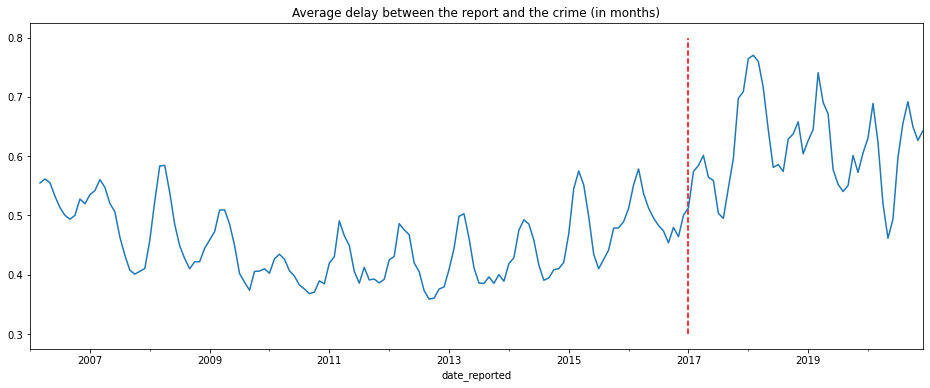

In [263]:
plt.figure(figsize=(16,6))

sex_crimes_reports = df_late_report[df_late_report.offense_desc.isin(('SEX CRIMES', 'RAPE'))]\
    .groupby(df_late_report.date_reported.dt.to_period('M')).count().cmp_id

sex_crimes_reports.plot(label='number of reported cases', ls='-.', color='grey')
sex_crimes_reports.rolling(6).mean().plot(label='rolling mean', ls='-', color='green')

plt.vlines(['2017-01'], ymin=0, ymax=40, label='Me Too Movement begins', color='red', ls='--')
plt.vlines(['2018-05'], ymin=0, ymax=40, label='Harvey Weinstein charged', color='red', ls='--')
plt.fill_betweenx(sex_crimes_reports, '2017-01', '2018-05', color='red', alpha=0.1)

plt.legend()
plt.title('Sex crimes reports with 10+ years delay before and after Me Too movement (NYC)')

plt.figure(figsize=(16,6))
(df_cmp.groupby(df_cmp.date_reported.dt.to_period('M')).crime_till_report.mean() / 30)\
    .rolling(3).mean().plot()
plt.vlines(['2017-01'], ymin=0.3, ymax=0.8, label='Me Too Movement begins', color='red', ls='--')
plt.title('Average delay between the report and the crime (in months)')

<AxesSubplot:xlabel='date_reported'>

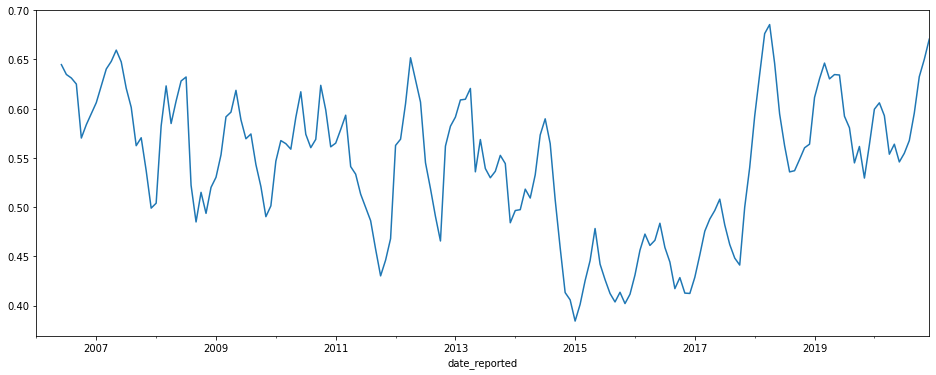

In [342]:
plt.figure(figsize=(16,6))
(df_cmp.groupby(df_cmp.date_reported.dt.to_period('M')).crime_till_report.mean()/30).rolling(6).mean().plot()